In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cdflib 
from cdflib import cdfepoch
from pathlib import Path
import pickle
from datetime import date
import cartopy

In [83]:
#ACCファイルの変数名を確認
cdf = cdflib.CDF("data/swarm/2020_ACC/SW_OPER_DNSCACC_2__20200216T000000_20200216T235950_0201.cdf")

info = cdf.cdf_info()
print("rVariables:", info.rVariables)
print("zVariables:", info.zVariables)
print(info)

rVariables: []
zVariables: ['time', 'density', 'altitude', 'latitude', 'longitude', 'local_solar_time']
CDFInfo(CDF=PosixPath('/workspace/data/swarm/2020_ACC/SW_OPER_DNSCACC_2__20200216T000000_20200216T235950_0201.cdf'), Version='3.6.3', Encoding=6, Majority='Row_major', rVariables=[], zVariables=['time', 'density', 'altitude', 'latitude', 'longitude', 'local_solar_time'], Attributes=[{'TITLE': 'Global'}, {'ORIGINAL_PRODUCT_NAME': 'Global'}, {'CREATOR': 'Global'}, {'TIME SYSTEM': 'Global'}, {'VARIABLE DESCRIPTION': 'Variable'}, {'UNITS': 'Variable'}, {'FORMAT': 'Variable'}, {'FILLVAL': 'Variable'}, {'SATELLITE': 'Global'}, {'DESCRIPTION': 'Global'}, {'DAILY_QUALITY_INDEX': 'Global'}], Copyright='\nCommon Data Format (CDF)\n(C) Copyright 1990-2016 NASA/GSFC\nSpace Physics Data Facility\nNASA/Goddard Space Flight Center\nGreenbelt, Maryland 20771 USA\n(Internet -- GSFC-CDF-SUPPORT@LISTS.NASA.GOV)\n', Checksum=False, Num_rdim=0, rDim_sizes=[], Compressed=False, LeapSecondUpdate=None)


In [84]:
#PODファイルの変数名を確認
cdf = cdflib.CDF("data/swarm/2020_POD/SW_OPER_DNSCPOD_2__20200216T000000_20200216T235930_0201.cdf")
info = cdf.cdf_info()
print("rVariables:", info.rVariables)
print("zVariables:", info.zVariables)
print(info)

rVariables: []
zVariables: ['time', 'density', 'density_orbitmean', 'validity_flag', 'altitude', 'latitude', 'longitude', 'local_solar_time']
CDFInfo(CDF=PosixPath('/workspace/data/swarm/2020_POD/SW_OPER_DNSCPOD_2__20200216T000000_20200216T235930_0201.cdf'), Version='3.6.3', Encoding=6, Majority='Row_major', rVariables=[], zVariables=['time', 'density', 'density_orbitmean', 'validity_flag', 'altitude', 'latitude', 'longitude', 'local_solar_time'], Attributes=[{'TITLE': 'Global'}, {'ORIGINAL_PRODUCT_NAME': 'Global'}, {'CREATOR': 'Global'}, {'TIME SYSTEM': 'Global'}, {'VARIABLE DESCRIPTION': 'Variable'}, {'UNITS': 'Variable'}, {'FORMAT': 'Variable'}, {'FILLVAL': 'Variable'}, {'SATELLITE': 'Global'}, {'DESCRIPTION': 'Global'}, {'ORBITAL_PERIOD_SECONDS': 'Global'}], Copyright='\nCommon Data Format (CDF)\n(C) Copyright 1990-2016 NASA/GSFC\nSpace Physics Data Facility\nNASA/Goddard Space Flight Center\nGreenbelt, Maryland 20771 USA\n(Internet -- GSFC-CDF-SUPPORT@LISTS.NASA.GOV)\n', Checksum=

In [85]:
f = Path("data") / "swarm" / "2020_POD" / "SW_OPER_DNSCPOD_2__20200216T000000_20200216T235930_0201.cdf"
cdf = cdflib.CDF(str(f))

# density 変数の属性を表示
print(cdf.varattsget("density"))

print(cdf.varattsget("altitude"))

{'VARIABLE DESCRIPTION': 'Density derived from GPS accelerations (FAST)', 'UNITS': 'kg/m3', 'FORMAT': 'E16.9', 'FILLVAL': '0.99900E+33'}
{'VARIABLE DESCRIPTION': 'Altitude', 'UNITS': 'm', 'FORMAT': 'E16.9', 'FILLVAL': '0.99900E+33'}


In [86]:
#pandasDataFrameにすることによって時系列データを扱える
#cdf→DataFrameをするための関数を定義
def read_cdf_to_df(path: Path, time_var="time", var_map=None) -> pd.DataFrame:
    """
    CDFを読み、index=time（UTC）、列に var_map で指定した変数を入れた DataFrame を返す。
    var_map: {出力列名: CDF変数名}
    """
    #cdfファイル読み取り
    c = cdflib.CDF(str(path))
    #時刻配列を Datetime に変換し、DataFrameIndex にする
    t = pd.to_datetime(cdfepoch.to_datetime(c.varget(time_var)))  # UTC naive
    df = pd.DataFrame(index=pd.DatetimeIndex(t, name="time"))
    
    if var_map:
        for out, var in var_map.items():
            arr = np.asarray(c.varget(var))
            if arr.ndim == 1 and len(arr) == len(df):
                # --- ここから: FILLVAL を NaN に ---
                try:
                    atts = c.varattsget(var)
                    fill = atts.get("FILLVAL", None)
                    if isinstance(fill, str):
                        # "0.99900E+33" のような文字列も欠損値とする
                        fill = float(fill.replace("D", "E"))
                    if fill is not None:
                        arr = np.where(arr == fill, np.nan, arr)
                    # 念のため、1e30 以上は欠損扱いとした
                    arr = np.where(arr > 1e30, np.nan, arr)
                except Exception:
                    pass
                # --- ここまで ---
                df[out] = arr
    return df.sort_index()

def bin_one_day(df: pd.DataFrame, date: str, secs: int, cols: list) -> pd.DataFrame:
    """
    指定日のデータを 'secs' 秒間隔の等間隔グリッドに詰め直す。
    例) POD: secs=30 -> 2880点, ACC: secs=10 -> 8640点
    cols: グリッド化対象の列名（例: ['density','altitude', ...]）
    """
    day = pd.to_datetime(date).date()
    d = df.loc[df.index.date == day].copy()
    if d.empty:
        # 空でも正しい長さのNaNで返す
        start = pd.Timestamp(str(day))
        idx = pd.date_range(start, start + pd.Timedelta(days=1) - pd.Timedelta(seconds=secs), freq=f"{secs}S")
        out = pd.DataFrame(index=idx, columns=cols, dtype=float)
        return out

    # その日の秒（00:00:00 からの経過秒）
    sec_of_day = (d.index - pd.Timestamp(str(day))).total_seconds()
    # どのバケット（0..n_bins-1）に入るか
    bin_idx = np.floor_divide(sec_of_day + secs/2, secs).astype(int)  # 最近傍に丸め
    n_bins = int(24*3600 // secs)

    # グリッドの時間軸
    start = pd.Timestamp(str(day))
    grid_index = pd.date_range(start, start + pd.Timedelta(days=1) - pd.Timedelta(seconds=secs), freq=f"{secs}s")

    # 初期化（NaNで満たす）
    out = pd.DataFrame(index=grid_index, columns=cols, dtype=float)

    # 同じバケットに複数サンプルが来た場合は平均（お好みで最新値などに変更可）
    for c in cols:
        tmp = pd.DataFrame({"bin": bin_idx, c: d[c].to_numpy(dtype=float)})
        grouped = tmp.groupby("bin")[c].mean()  # 代表値の定義：平均
        valid_bins = grouped.index[(grouped.index >= 0) & (grouped.index < n_bins)]
        out.loc[out.index[valid_bins], c] = grouped.loc[valid_bins].values

    return out

In [87]:

# === 設定 ===
CHOICE = "POD"   # "POD" か "ACC"
YEAR   = 2020    # 先生コードと同じ条件
ROOT   = Path("data")  # あなたの data/ のルート

# === ファイル探索 ===
if CHOICE.upper() == "POD":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "POD" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
        "validity_flag": "validity_flag",
        "density_orbitmean": "density_orbitmean",
    }
    bin_secs = 30      # 30秒 -> 2880点
elif CHOICE.upper() == "ACC":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "ACC" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
    }
    bin_secs = 10      # 10秒 -> 8640点
else:
    raise ValueError("CHOICE must be 'POD' or 'ACC'")

print(f"Found {len(files)} {CHOICE} files in {YEAR}")

# === 読み込み & 日単位グリッド化 → DNS 辞書に格納 ===
DNS = {}  # {doy: DataFrame(columns=cols + meta)}

for f in files:
    # ファイル→DF
    df = read_cdf_to_df(f, time_var="time", var_map=var_map)

    # POD: validity_flagがあればフィルタ（1を有効と想定）
    CHOICE = "POD"
    YEAR = 2020

    # ファイル内に含まれるユニークな日を順に処理
    for date in sorted({ts.date() for ts in df.index}):
        date_str = str(date)
        # 欲しい列（DNSに入れたいコア項目）
        cols = [c for c in ["density","altitude","latitude","longitude","local_solar_time","validity_flag","density_orbitmean"] if c in df.columns]
        binned = bin_one_day(df, date_str, secs=bin_secs, cols=cols)

        # doy を MATLAB と同様に 1始まりで計算
        doy = (pd.Timestamp(date_str) - pd.Timestamp(f"{YEAR}-01-01")).days + 1

        # T（先生コードの day-of-year 小数日）相当を入れるなら：
        # 小数日 = (doy-1) + (経過秒 / 86400)
        seconds = (binned.index - pd.Timestamp(date_str)).total_seconds()
        T = (doy - 1) + seconds / 86400.0

        # ymd は [Y M D h m s] を入れたい場合
        ymd = np.column_stack([
            np.full(len(binned), int(date_str[:4])),
            np.full(len(binned), int(date_str[5:7])),
            np.full(len(binned), int(date_str[8:10])),
            binned.index.hour, binned.index.minute, binned.index.second
        ])

        # DNS[doy] を DataFrame で持つ（先生の構造体に相当）
        out = binned.copy()
        out["T"] = T
        # 必要なら ymd は別管理でもOK（ここでは別キーに入れる）
        DNS[doy] = {"data": out, "ymd": ymd, "date": date_str}

print(f"Days collected: {len(DNS)}")

# === 保存 ===
# Python（pickle）
import pickle
save_path = Path(f"DNS_{CHOICE}_{YEAR}.pkl")
with open(save_path, "wb") as f:
    pickle.dump(DNS, f)
print("Saved:", save_path)


Found 121 POD files in 2020
Days collected: 121
Saved: DNS_POD_2020.pkl


In [88]:
# === 設定 ===
CHOICE = "ACC"   # "POD" か "ACC"
YEAR   = 2020    # 先生コードと同じ条件
ROOT   = Path("data")  # あなたの data/ のルート

# === ファイル探索 ===
if CHOICE.upper() == "POD":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "POD" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
        "validity_flag": "validity_flag",
        "density_orbitmean": "density_orbitmean",
    }
    bin_secs = 30      # 30秒 -> 2880点
elif CHOICE.upper() == "ACC":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "ACC" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
    }
    bin_secs = 10      # 10秒 -> 8640点
else:
    raise ValueError("CHOICE must be 'POD' or 'ACC'")

print(f"Found {len(files)} {CHOICE} files in {YEAR}")

# === 読み込み & 日単位グリッド化 → DNS 辞書に格納 ===
DNS = {}  # {doy: DataFrame(columns=cols + meta)}

for f in files:
    # ファイル→DF
    df = read_cdf_to_df(f, time_var="time", var_map=var_map)

    # POD: validity_flagがあればフィルタ（1を有効と想定）
    CHOICE = "POD"
    YEAR = 2020

    # ファイル内に含まれるユニークな日を順に処理
    for date in sorted({ts.date() for ts in df.index}):
        date_str = str(date)
        # 欲しい列（DNSに入れたいコア項目）
        cols = [c for c in ["density","altitude","latitude","longitude","local_solar_time","validity_flag","density_orbitmean"] if c in df.columns]
        binned = bin_one_day(df, date_str, secs=bin_secs, cols=cols)

        # doy を MATLAB と同様に 1始まりで計算
        doy = (pd.Timestamp(date_str) - pd.Timestamp(f"{YEAR}-01-01")).days + 1

        # T（先生コードの day-of-year 小数日）相当を入れるなら：
        # 小数日 = (doy-1) + (経過秒 / 86400)
        seconds = (binned.index - pd.Timestamp(date_str)).total_seconds()
        T = (doy - 1) + seconds / 86400.0

        # ymd は [Y M D h m s] を入れたい場合
        ymd = np.column_stack([
            np.full(len(binned), int(date_str[:4])),
            np.full(len(binned), int(date_str[5:7])),
            np.full(len(binned), int(date_str[8:10])),
            binned.index.hour, binned.index.minute, binned.index.second
        ])

        # DNS[doy] を DataFrame で持つ（先生の構造体に相当）
        out = binned.copy()
        out["T"] = T
        # 必要なら ymd は別管理でもOK（ここでは別キーに入れる）
        DNS[doy] = {"data": out, "ymd": ymd, "date": date_str}

print(f"Days collected: {len(DNS)}")

# === 保存===
# Python（pickle）
save_path = Path(f"DNS_ACC_{YEAR}.pkl")
with open(save_path, "wb") as f:
    pickle.dump(DNS, f)
print("Saved:", save_path)

Found 75 ACC files in 2020
Days collected: 75
Saved: DNS_ACC_2020.pkl


In [89]:
from datetime import date
DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))

k = (date(2020,2,16) - date(2020,1,1)).days + 1
print(DNS_POD[k]["data"].head())

                          density       altitude   latitude  longitude  \
2020-02-16 00:00:00  3.392699e-14  436585.890104  30.913148  32.537153   
2020-02-16 00:00:30  2.804285e-14  436853.813673  32.847714  32.535136   
2020-02-16 00:01:00  2.218418e-14  437144.423965  34.781536  32.538580   
2020-02-16 00:01:30  1.649032e-14  437455.438470  36.714574  32.548170   
2020-02-16 00:02:00  1.093662e-14  437784.471408  38.646789  32.564683   

                     local_solar_time  validity_flag  density_orbitmean  \
2020-02-16 00:00:00          1.933607            0.0       1.207250e-13   
2020-02-16 00:00:30          1.941806            0.0       1.208599e-13   
2020-02-16 00:01:00          1.950369            0.0       1.209955e-13   
2020-02-16 00:01:30          1.959342            0.0       1.211308e-13   
2020-02-16 00:02:00          1.968777            0.0       1.212650e-13   

                             T  
2020-02-16 00:00:00  46.000000  
2020-02-16 00:00:30  46.000347  
2020-

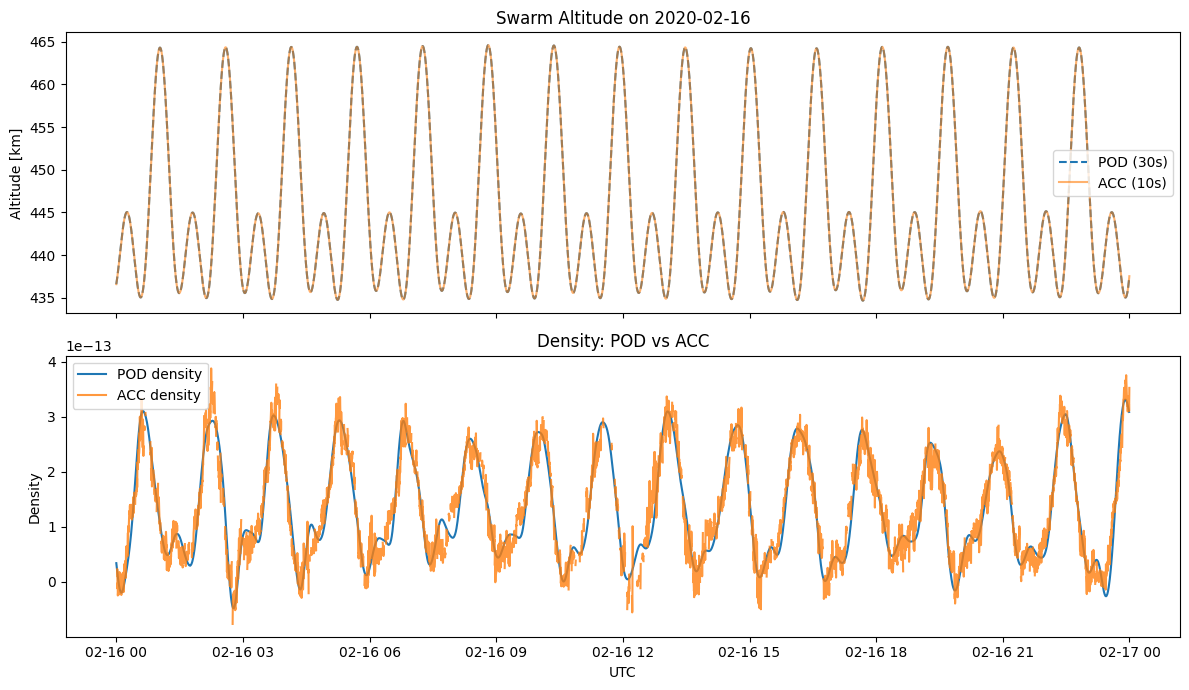

In [90]:
import datetime
# 読み込み
DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))

# 日付→DOY（2020基準）
def doy(dt):
    return (dt - datetime.date(2020,1,1)).days + 1

the_day = datetime.date(2020,2,16)
k = doy(the_day)

P = DNS_POD[k]["data"]
A = DNS_ACC[k]["data"]

# --- Plot ---
fig, axes = plt.subplots(2,1,figsize=(12,7),sharex=True)

# 高度を km に変換してからプロット
axes[0].plot(P.index, P["altitude"]/1000, label="POD (30s)", linestyle="--")
axes[0].plot(A.index, A["altitude"]/1000, alpha=0.6, label="ACC (10s)", linestyle="-")
axes[0].set_ylabel("Altitude [km]")
axes[0].set_title(f"Swarm Altitude on {the_day}")
axes[0].legend()

# 密度
axes[1].plot(P.index, P["density"], label="POD density")
axes[1].plot(A.index, A["density"], alpha=0.8, label="ACC density")
axes[1].set_ylabel("Density")
axes[1].set_title("Density: POD vs ACC")
axes[1].legend()

plt.xlabel("UTC")
plt.tight_layout()
plt.show()

In [91]:
import datetime
#関数定義
# 2020年のDNS（POD/ACC）を読み込み　、monthlyで見たい時に月毎で取り出す用
DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))

def doy_2020(d: date) -> int:
    """2020-01-01 を 1 とする DOY（1始まり）"""
    return (d - date(2020,1,1)).days + 1

def day_df(DNS: dict, d: date, colname: str):
    k = doy_2020(d)
    if k not in DNS: return pd.DataFrame()
    df = DNS[k]["data"]
    # その日のみ抽出（UTC）
    start = pd.Timestamp(d.year, d.month, d.day)
    end   = start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    return df.loc[start:end].rename(columns={"density": colname}).sort_index()

def plot_days(dates, tolerance="30s", resample=None, sharey=True):
    n = len(dates)
    fig, axes = plt.subplots(n, 1, figsize=(14, 3.5*n), sharex=False, sharey=sharey)

    if n == 1:
        axes = [axes]
        packs = []
        for d in dates:
            P = day_df(DNS_POD, d, "rho_pod")
            A = day_df(DNS_ACC, d, "rho_acc")
            if P.empty or A.empty:
                packs.append((d, pd.DataFrame()))
                continue
                M = pd.merge_asof(P[["rho_pod"]],
                                  A[["rho_acc"]],
                                left_index=True, right_index=True,
                                direction="nearest", tolerance=pd.Timedelta(tolerance))
                if resample:
                    M = M.resample(resample).mean()
                    packs.append((d, M))

def concat_dns_range(DNS: dict, start, end, cols=None) -> pd.DataFrame:
    """
    DNS（{doy: {"data": DataFrame, ...}}）から、任意の期間[start, end]のデータを縦結合して返す。
    - start/end は str / pandas.Timestamp / datetime / date のいずれでもOK（UTC前提のnaiveで扱う）
    - cols に列名リストを渡すと、その列だけ抽出
    返り値：時刻昇順の DataFrame（存在しなければ空 DataFrame）
    """
    # 型をそろえる（endは一日の終端まで含む）
    start_ts = pd.to_datetime(start)
    end_ts   = pd.to_datetime(end)
    # もし end が日付だけなら 23:59:59.999999 まで含める
    if isinstance(end, (date, datetime.date)) and getattr(end, "hour", 0) == 0 and getattr(end, "minute", 0) == 0 and getattr(end, "second", 0) == 0:
        end_ts = end_ts.replace(hour=23, minute=59, second=59, microsecond=999999)

    frames = []
    for k in sorted(DNS.keys()):
        df = DNS[k].get("data")
        if df is None or df.empty:
            continue
        # 期間でスライス
        cut = df.loc[start_ts:end_ts]
        if not cut.empty:
            frames.append(cut[cols] if cols else cut)

    return pd.concat(frames).sort_index() if frames else pd.DataFrame()



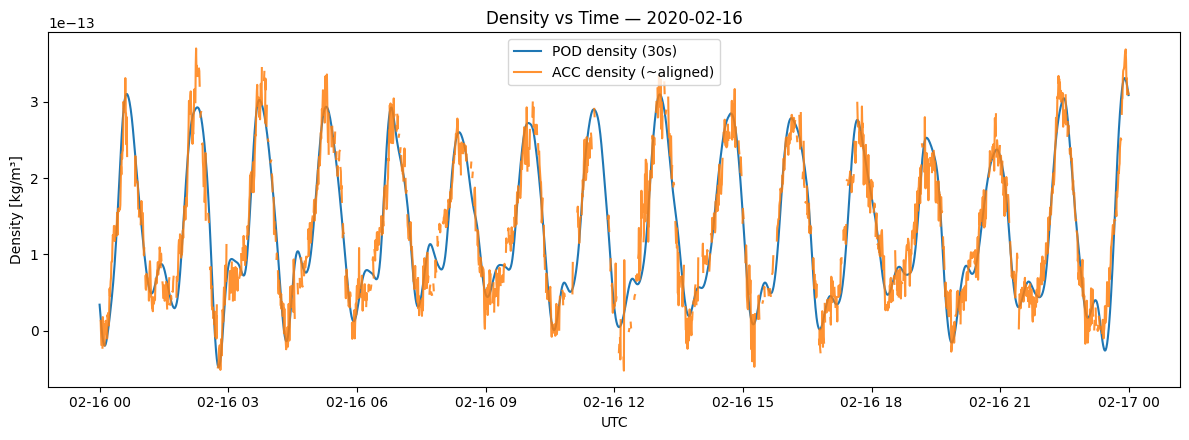

In [92]:
DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))
def doy_2020(d: date) -> int:
    """2020-01-01 を 1 とする DOY（1始まり）"""
    return (d - date(2020,1,1)).days + 1

#日にちごとで見るグラフプロット、1日間で見る場合
from datetime import date
# === 解析したい日付 ===
the_day = date(2020, 2, 16)  # ← 好きな日に変更

k = doy_2020(the_day)
P = DNS_POD.get(k, {}).get("data")
A = DNS_ACC.get(k, {}).get("data")

if P is None or A is None:
    raise ValueError(f"DNS に {the_day} の日が見つかりません（POD/ACCのどちらか欠け）")

# POD基準でACC密度を合わせる（±30s）
merged = pd.merge_asof(
    P.sort_index()[["density"]].rename(columns={"density":"rho_pod"}),
    A.sort_index()[["density"]].rename(columns={"density":"rho_acc"}),
    left_index=True, right_index=True,
    direction="nearest", tolerance=pd.Timedelta("30s")
)

fig, ax = plt.subplots(figsize=(12,4.5))
ax.plot(merged.index, merged["rho_pod"], label="POD density (30s)")
ax.plot(merged.index, merged["rho_acc"], label="ACC density (~aligned)", alpha=0.85)
ax.set_title(f"Density vs Time — {the_day.isoformat()}")
ax.set_ylabel("Density [kg/m³]")
ax.set_xlabel("UTC")
ax.legend()
plt.tight_layout(); plt.show()


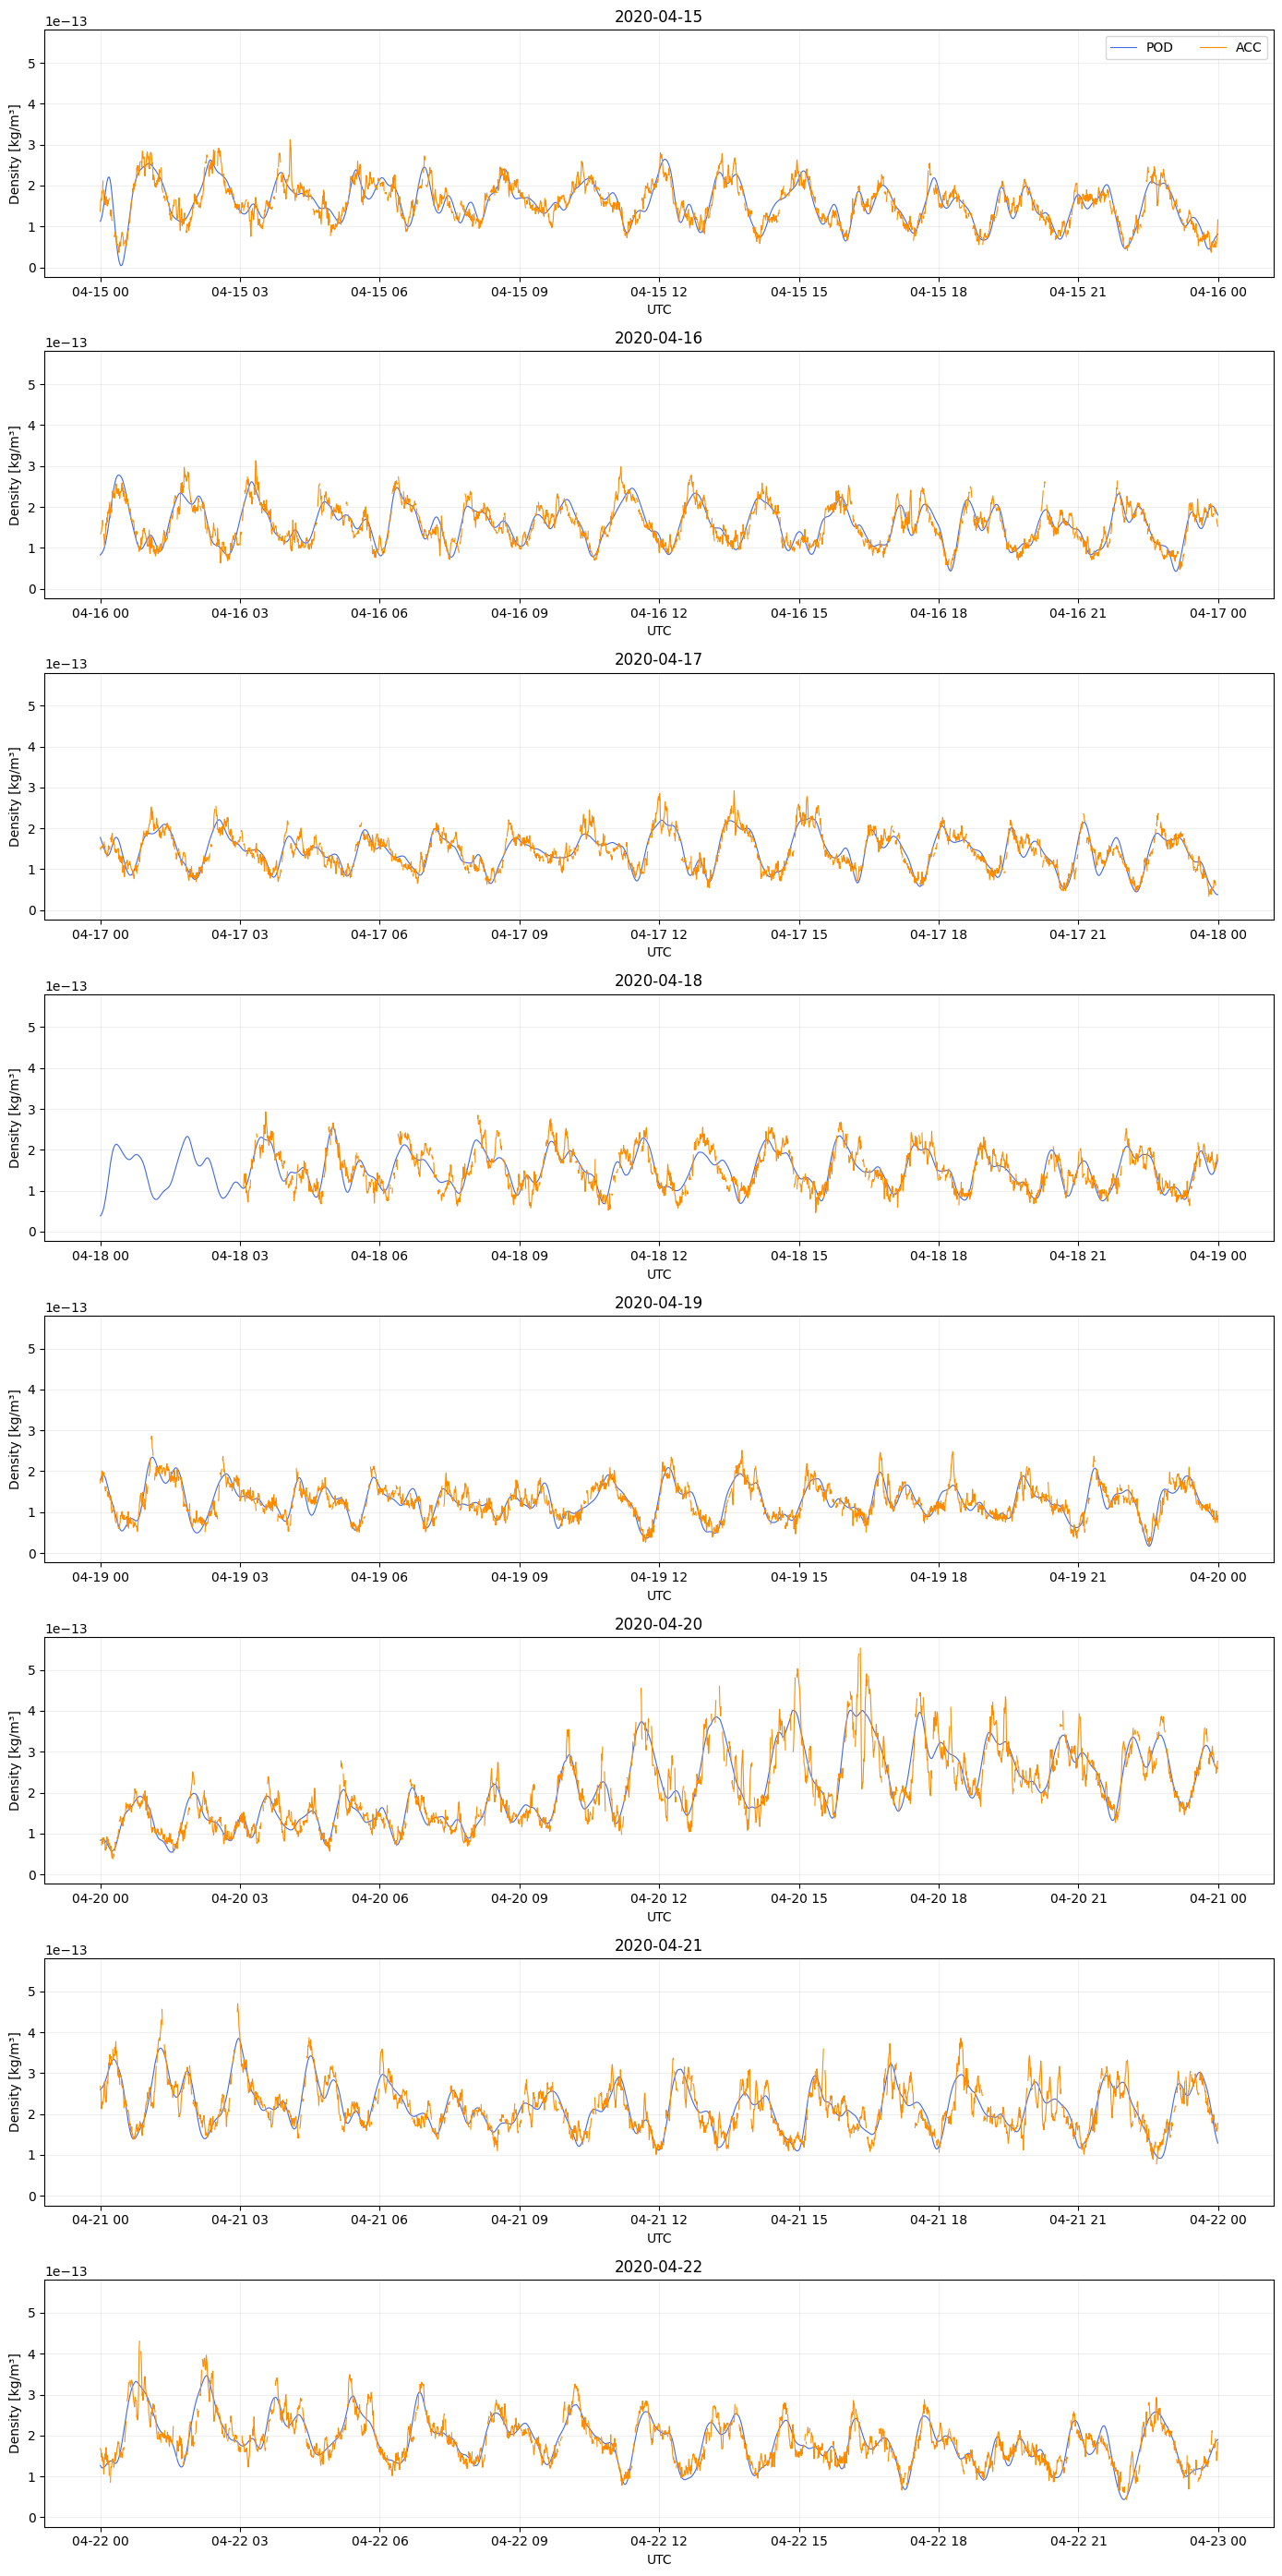

In [93]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import pandas as pd

def plot_days(dates, tolerance="30s", resample=None, sharey=True):
    n = len(dates)
    fig, axes = plt.subplots(n, 1, figsize=(14, 3.5*n),
                             sharex=False, sharey=sharey)
    if n == 1:
        axes = [axes]

    for ax, d in zip(axes, dates):
        P = day_df(DNS_POD, d, "rho_pod")
        A = day_df(DNS_ACC, d, "rho_acc")

        if P.empty or A.empty:
            ax.set_title(f"{d.isoformat()} (no data)")
            ax.set_xlabel("UTC")
            continue

        M = pd.merge_asof(
            P[["rho_pod"]], A[["rho_acc"]],
            left_index=True, right_index=True,
            direction="nearest", tolerance=pd.Timedelta(tolerance)
        )
        if resample:
            M = M.resample(resample).mean()

        ax.plot(M.index, M["rho_pod"], color="royalblue", linewidth=0.8, label="POD")
        ax.plot(M.index, M["rho_acc"], color="darkorange", linewidth=0.8, label="ACC")
        ax.set_title(d.isoformat())
        ax.set_ylabel("Density [kg/m³]")
        ax.grid(alpha=0.2)
        if ax is axes[0]:
            ax.legend(ncol=2)
        ax.set_xlabel("UTC")

    plt.tight_layout()
    plt.show()


def plot_days_range(start: date, end: date, tolerance="30s", resample=None, sharey=True):
    """start から end までの日付を自動生成して plot_days に渡す"""
    dates = [start + timedelta(days=i) for i in range((end - start).days + 1)]
    plot_days(dates, tolerance=tolerance, resample=resample, sharey=sharey)
# 例：2020/4/16〜2020/4/22 の1週間を表示
plot_days_range(date(2020,4,15), date(2020,4,22),
                tolerance="30s", resample=None, sharey=True)


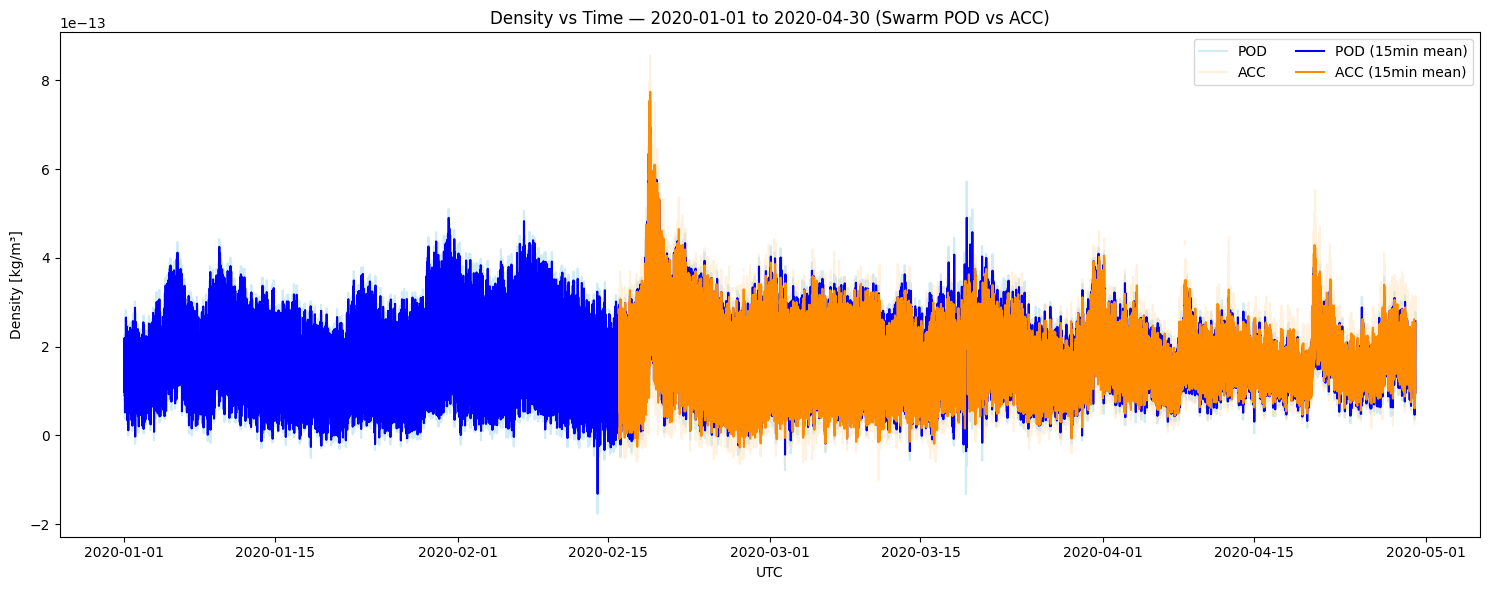

In [94]:

# 期間を指定（文字列でも date でもOK）
start, end = "2020-01-01", "2020-04-30"
# start, end = date(2020,1,1), date(2020,4,30)

# DNSを 1〜4月分に結合（必要列だけ取ると軽くなります）
P_all = concat_dns_range(DNS_POD, start, end, cols=["density"]).rename(columns={"density":"rho_pod"})
A_all = concat_dns_range(DNS_ACC, start, end, cols=["density"]).rename(columns={"density":"rho_acc"})

# 念のためのガード
if P_all.empty or A_all.empty:
    raise ValueError("指定期間にデータがありません（POD/ACCのどちらかが空）")

# PODを基準にACCを時間合わせ（±30秒）
merged = pd.merge_asof(
    P_all.sort_index()[["rho_pod"]],
    A_all.sort_index()[["rho_acc"]],
    left_index=True, right_index=True,
    direction="nearest", tolerance=pd.Timedelta("30s")
)

# 15分移動平均で平滑化
mv = merged.rolling("15min", min_periods=1).mean()

# === プロット ===
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(merged.index, merged["rho_pod"], color="skyblue", alpha=0.4, label="POD")
ax.plot(merged.index, merged["rho_acc"], color="navajowhite", alpha=0.4, label="ACC")
ax.plot(mv.index,     mv["rho_pod"],     color="blue",      label="POD (15min mean)")
ax.plot(mv.index,     mv["rho_acc"],     color="darkorange",label="ACC (15min mean)")
ax.set_title(f"Density vs Time — {pd.to_datetime(start).date()} to {pd.to_datetime(end).date()} (Swarm POD vs ACC)")
ax.set_ylabel("Density [kg/m³]")
ax.set_xlabel("UTC")
ax.legend(ncol=2)
plt.tight_layout(); plt.show()



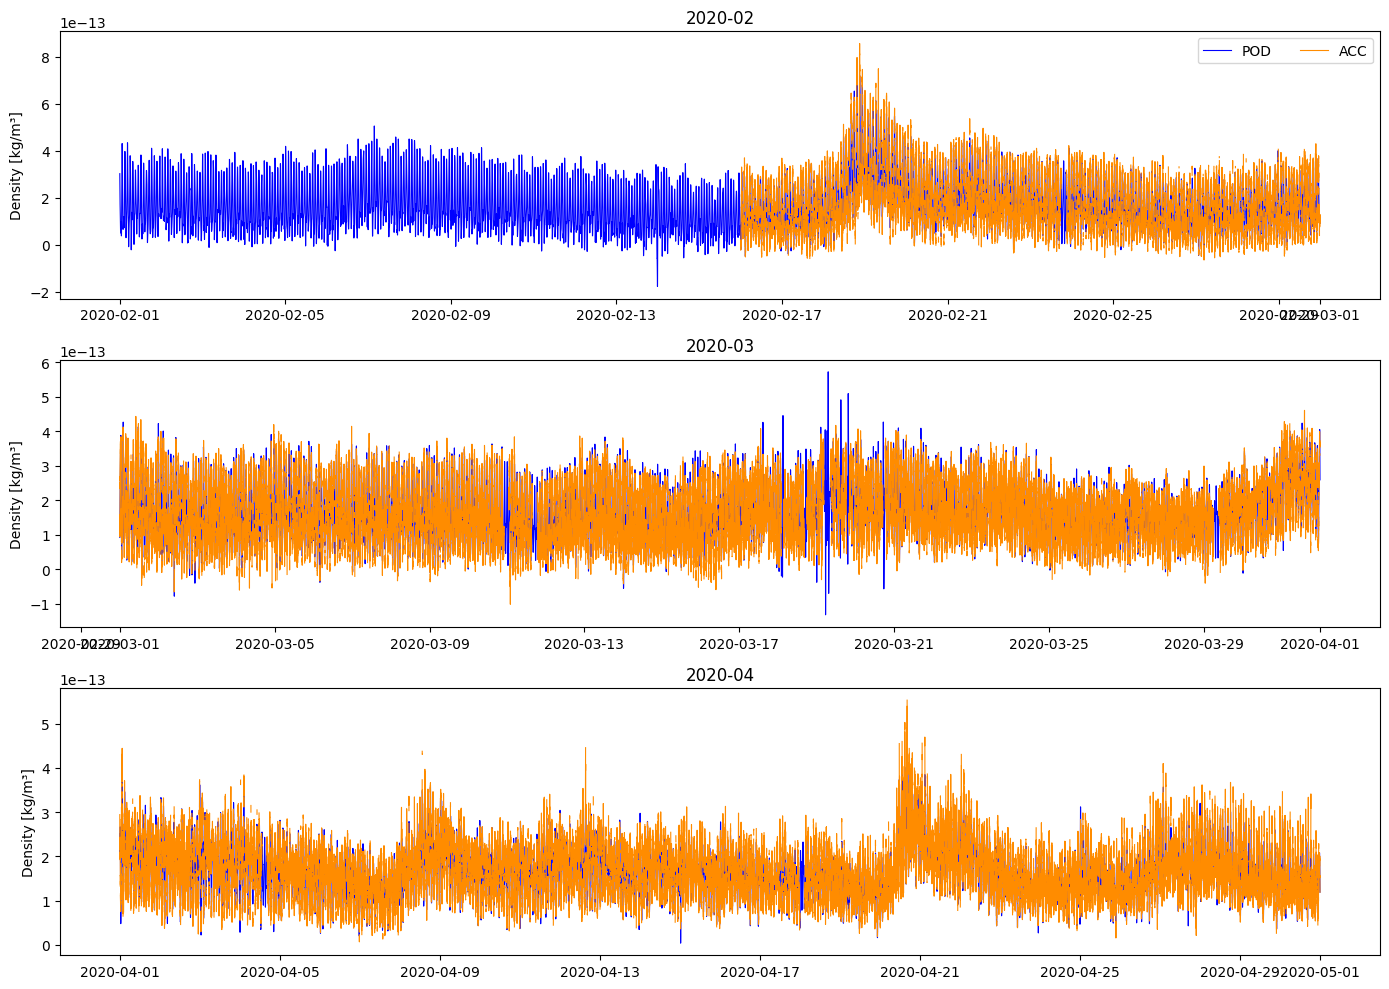

In [95]:
DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))
def concat_dns_month(DNS, y, m):
    start = pd.Timestamp(y, m, 1)
    end   = (start + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    frames=[]
    for k in sorted(DNS.keys()):
        df = DNS[k]["data"]
        if not df.empty:
            cut = df.loc[start:end]
            if not cut.empty: frames.append(cut)
    return pd.concat(frames).sort_index() if frames else pd.DataFrame()

fig, axes = plt.subplots(3, 1, figsize=(14,10), sharex=False)
for i, m in enumerate([2,3,4]):
    P = concat_dns_month(DNS_POD, 2020, m).rename(columns={"density":"rho_pod"})
    A = concat_dns_month(DNS_ACC, 2020, m).rename(columns={"density":"rho_acc"})
    if P.empty or A.empty:
        axes[i].set_title(f"2020-{m:02d} (no data)"); continue
    
    M = pd.merge_asof(P[["rho_pod"]].sort_index(),
                        A[["rho_acc"]].sort_index(),
                        left_index=True, right_index=True,
                        direction="nearest", tolerance=pd.Timedelta("30s"))
    
# 生データのみプロット
    axes[i].plot(M.index, M["rho_pod"], color="blue",  linewidth=0.8, label="POD")
    axes[i].plot(M.index, M["rho_acc"], color="darkorange", linewidth=0.8, label="ACC")

    axes[i].set_ylabel("Density [kg/m³]")
    axes[i].set_title(f"2020-{m:02d}")
    if i==0: axes[i].legend(ncol=2)

plt.tight_layout()
plt.show()


In [96]:
# 任意変数をPOD/ACCで同じ月に重ね描き
def plot_var_months(DNS_POD, DNS_ACC, year, months, var='density', label=None, scale=1.0,
                    tolerance='30s'):
    fig, axes = plt.subplots(len(months), 1, figsize=(14, 3.2*len(months)), sharex=False)
    if len(months) == 1:
        axes = [axes]
    for i, m in enumerate(months):
        P = concat_dns_month(DNS_POD, year, m)
        A = concat_dns_month(DNS_ACC, year, m)
        if P.empty or A.empty or (var not in P.columns) or (var not in A.columns):
            axes[i].set_title(f"{year}-{m:02d} (no data)"); axes[i].set_ylabel(label or var); continue

        # 列名をPOD/ACCで分けておく
        P = P[[var]].rename(columns={var: f'{var}_pod'}).sort_index()
        A = A[[var]].rename(columns={var: f'{var}_acc'}).sort_index()

        M = pd.merge_asof(P, A, left_index=True, right_index=True,
                          direction="nearest", tolerance=pd.Timedelta(tolerance))

        # スケール（例：density×1e13, altitude×1e-3 など）
        if scale != 1.0:
            M = M * scale

        axes[i].plot(M.index, M[f'{var}_pod'], color="blue", linewidth=0.8, label="POD")
        axes[i].plot(M.index, M[f'{var}_acc'], color="darkorange", linewidth=0.8, label="ACC")
        axes[i].set_title(f"{year}-{m:02d}")
        axes[i].set_ylabel(label or var)
        if i == 0:
            axes[i].legend(ncol=2)

    plt.tight_layout()
    plt.show()


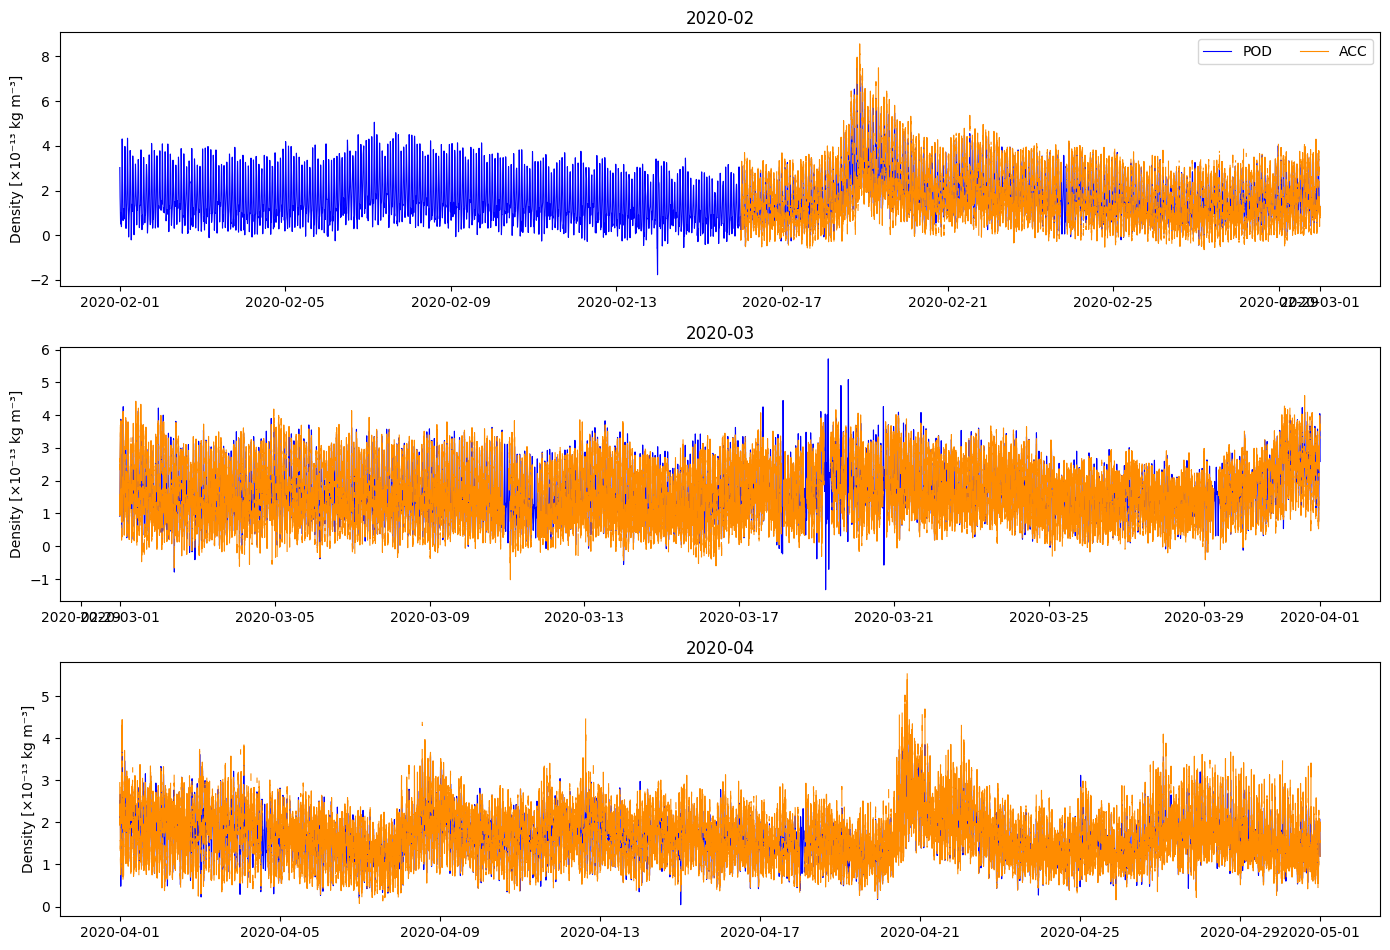

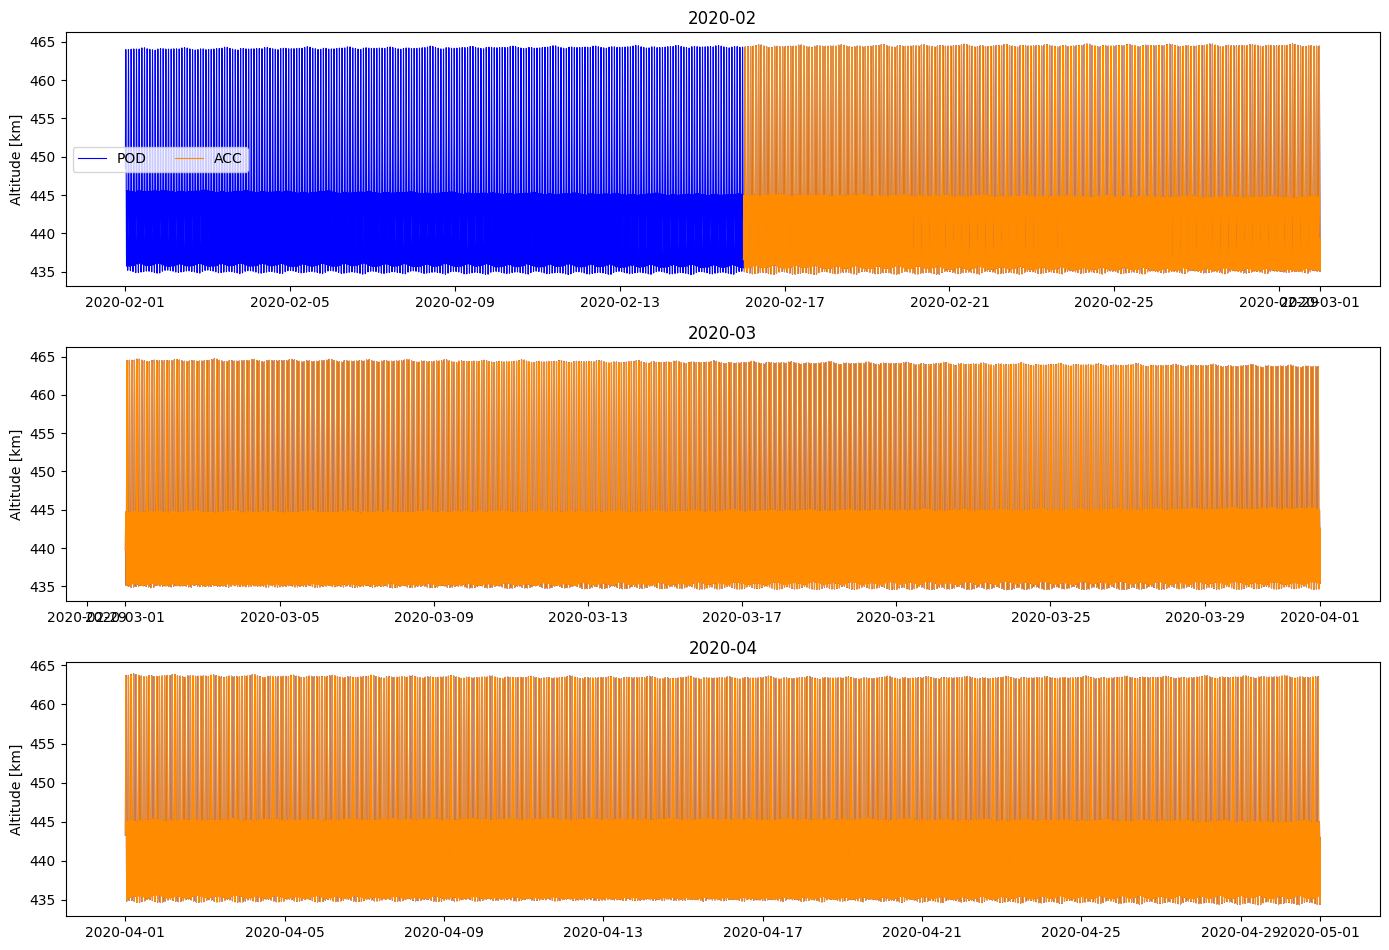

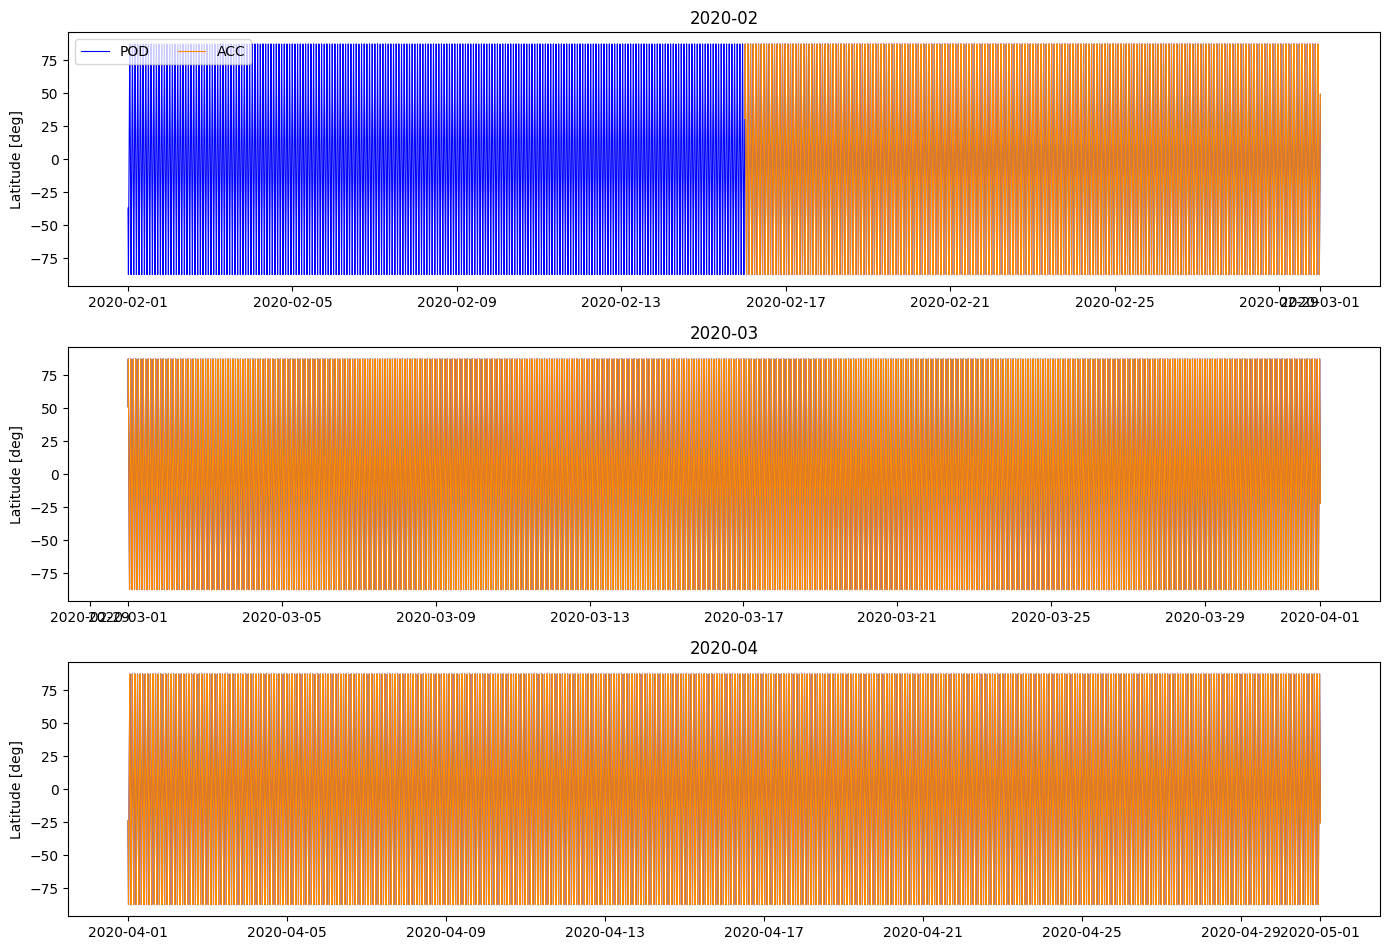

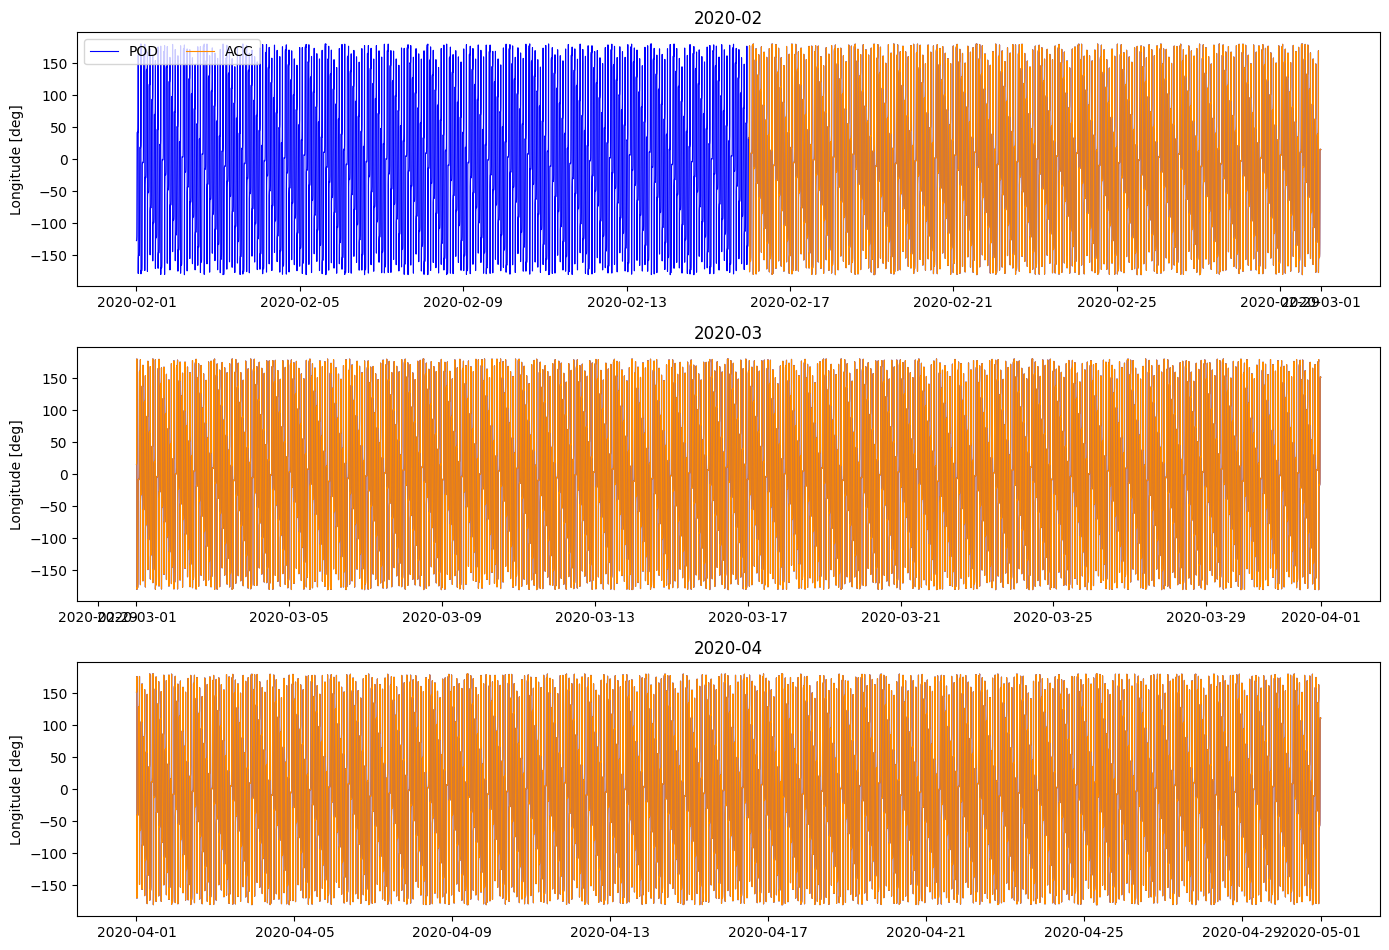

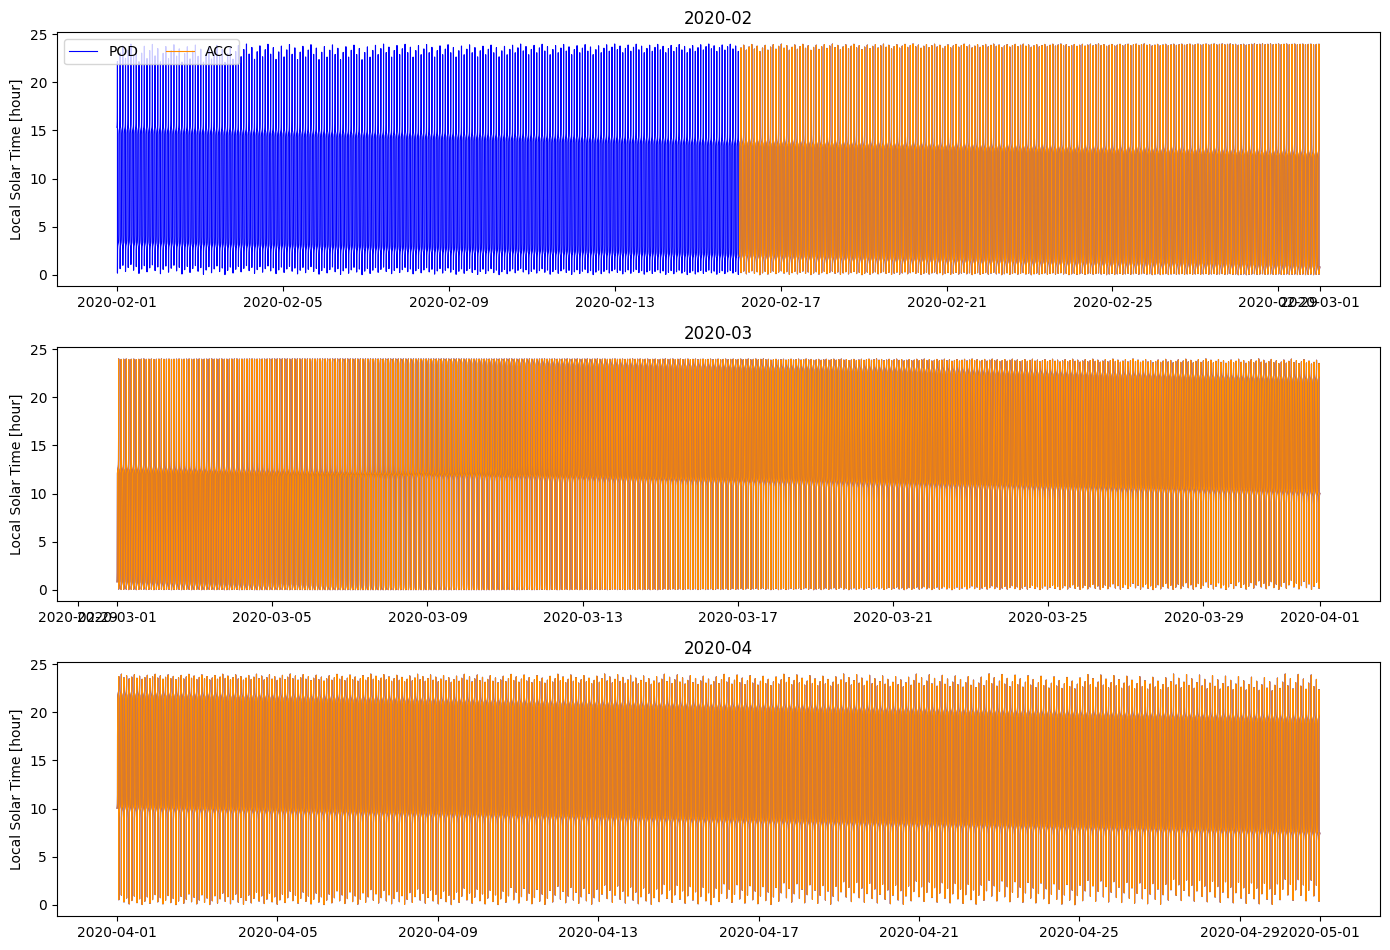

In [97]:
# 1) これまで通り density（単位を×10^-13表示したい場合）
plot_var_months(DNS_POD, DNS_ACC, 2020, [2,3,4],
                var='density', label='Density [×10⁻¹³ kg m⁻³]', scale=1e13)

# 2) 高度（m→km にしたい）
plot_var_months(DNS_POD, DNS_ACC, 2020, [2,3,4],
                var='altitude', label='Altitude [km]', scale=1e-3)

# 3) 緯度・経度（スケール不要）
plot_var_months(DNS_POD, DNS_ACC, 2020, [2,3,4],
                var='latitude',  label='Latitude [deg]')
plot_var_months(DNS_POD, DNS_ACC, 2020, [2,3,4],
                var='longitude', label='Longitude [deg]')

# 4) Local solar time（そのまま）
plot_var_months(DNS_POD, DNS_ACC, 2020, [2,3,4],
                var='local_solar_time', label='Local Solar Time [hour]')


In [98]:
# 日付→DOY（2020年基準の例。必要なら汎用化してね）
def doy_2020(d: date) -> int:
    return (d - date(2020,1,1)).days + 1

def day_slice(df: pd.DataFrame, d: date):
    start = pd.Timestamp(d.year, d.month, d.day)
    end   = start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    return df.loc[start:end]

def plot_var_days(DNS_POD, DNS_ACC, dates, var='density', label=None, scale=1.0,
                  tolerance='30s', resample=None):
    fig, axes = plt.subplots(len(dates), 1, figsize=(14, 3.2*len(dates)), sharex=False)
    if len(dates) == 1:
        axes = [axes]

    for i, d in enumerate(dates):
        k = doy_2020(d)
        P = DNS_POD.get(k, {}).get("data", pd.DataFrame())
        A = DNS_ACC.get(k, {}).get("data", pd.DataFrame())

        if P is None or A is None or P.empty or A.empty or (var not in P.columns) or (var not in A.columns):
            axes[i].set_title(f"{d.isoformat()} (no data)")
            axes[i].set_ylabel(label or var)
            continue

        P = day_slice(P, d)[[var]].rename(columns={var: f'{var}_pod'}).sort_index()
        A = day_slice(A, d)[[var]].rename(columns={var: f'{var}_acc'}).sort_index()

        if resample:
            P = P.resample(resample).mean()
            A = A.resample(resample).mean()

        M = pd.merge_asof(P, A, left_index=True, right_index=True,
                          direction="nearest", tolerance=pd.Timedelta(tolerance))

        if scale != 1.0:
            M = M * scale

        axes[i].plot(M.index, M[f'{var}_pod'], color="blue", linewidth=0.9, label="POD")
        axes[i].plot(M.index, M[f'{var}_acc'], color="darkorange", linewidth=0.9, label="ACC")
        axes[i].set_title(d.isoformat())
        axes[i].set_ylabel(label or var)
        if i == 0:
            axes[i].legend(ncol=2)

    plt.tight_layout()
    plt.show()

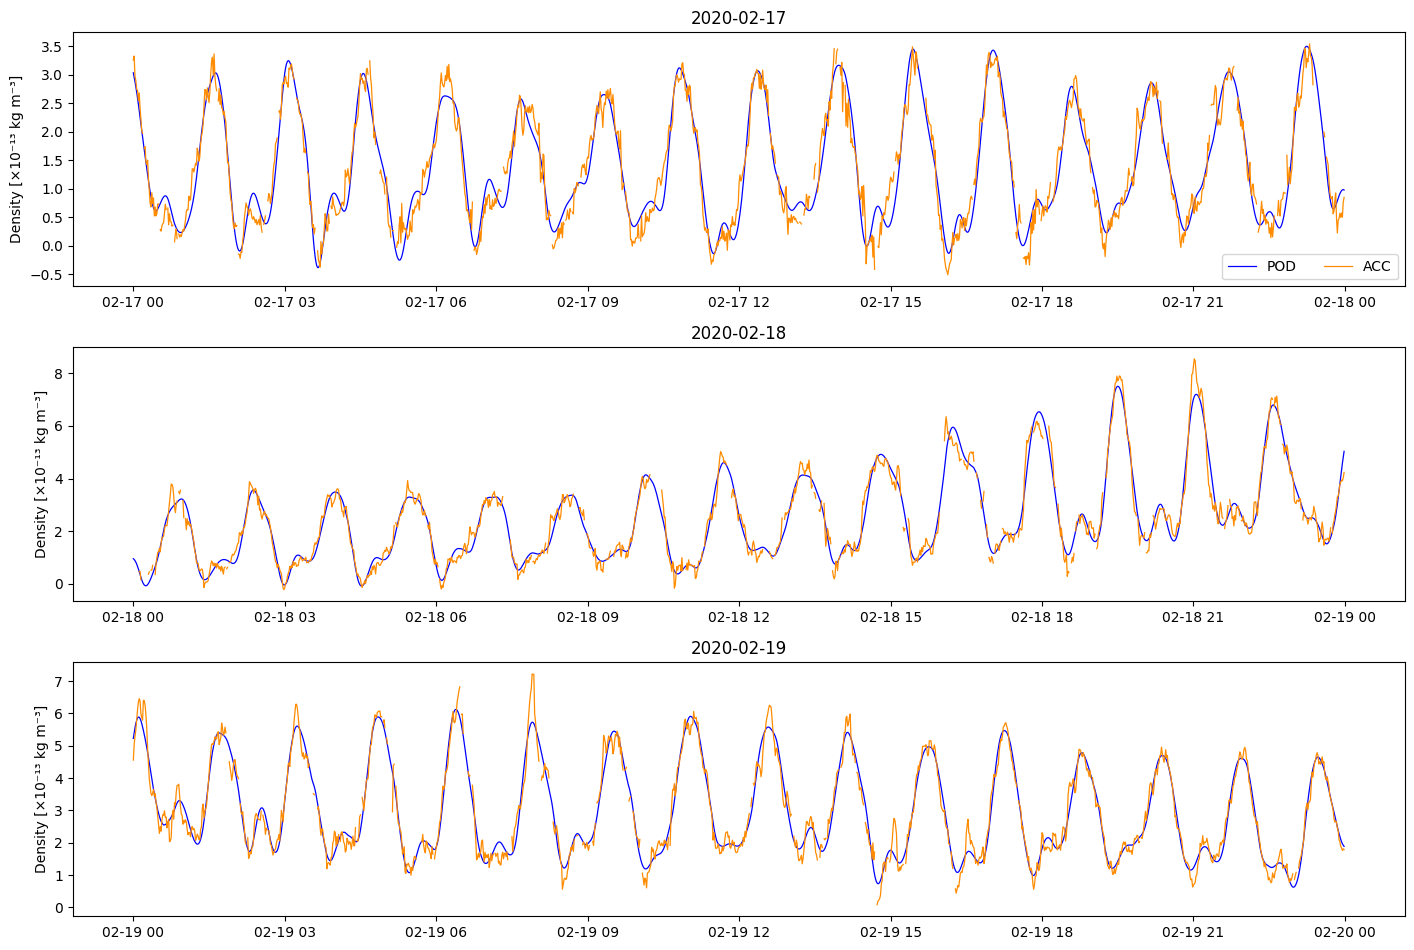

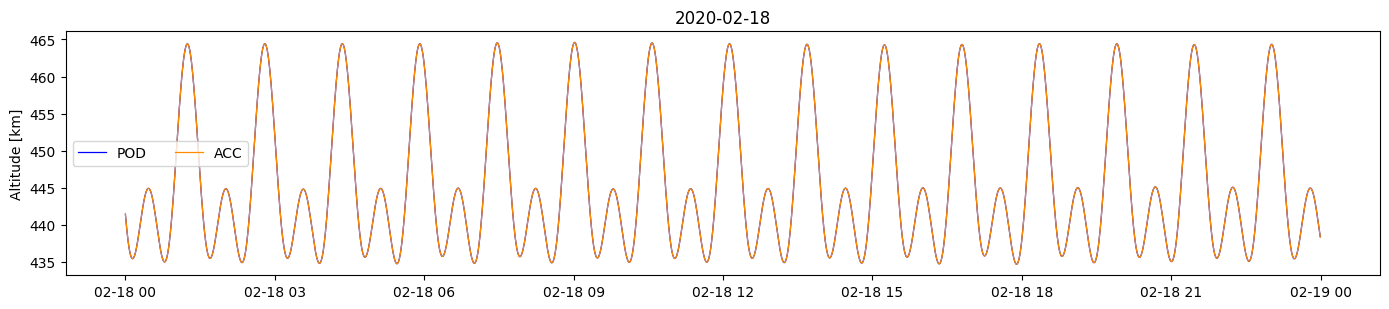

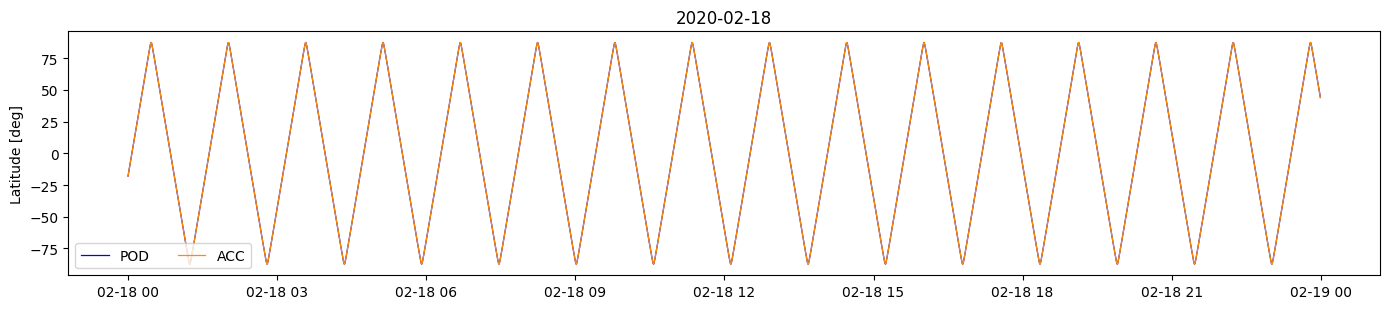

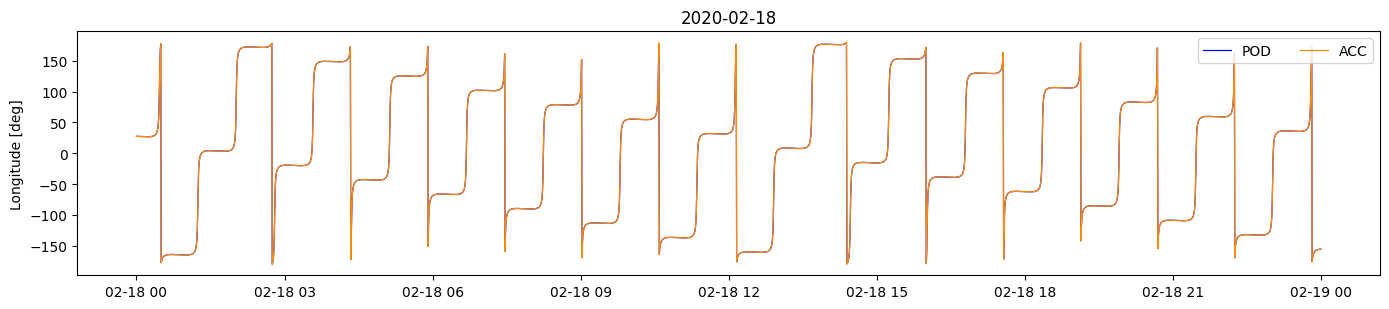

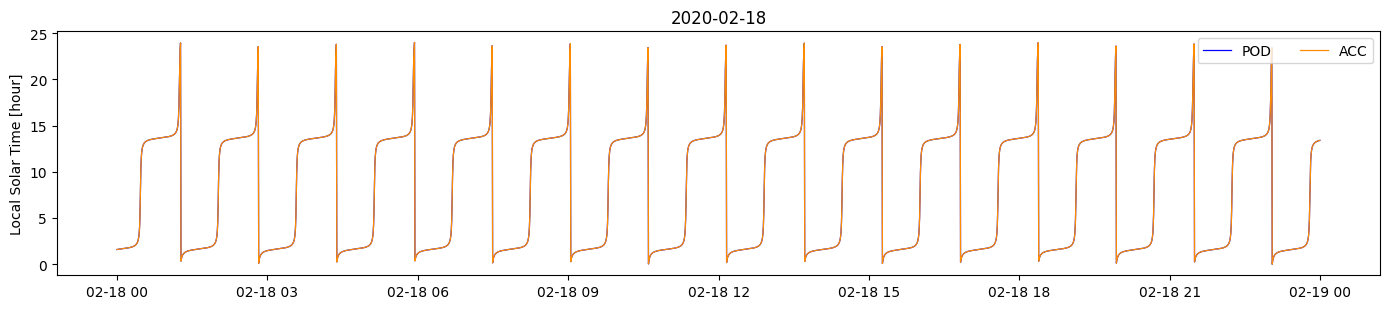

In [99]:

# 1) density（×10^-13 表示）
plot_var_days(DNS_POD, DNS_ACC,
              dates=[date(2020,2,17), date(2020,2,18), date(2020,2,19)],
              var='density', label='Density [×10⁻¹³ kg m⁻³]', scale=1e13,
              tolerance='30s', resample='1min')  # resampleは任意

# 2) 高度（m→km）
plot_var_days(DNS_POD, DNS_ACC,
              dates=[date(2020,2,18)],
              var='altitude', label='Altitude [km]', scale=1e-3,
              tolerance='30s')

# 3) 緯度・経度・地方時
plot_var_days(DNS_POD, DNS_ACC, [date(2020,2,18)], var='latitude', label='Latitude [deg]')
plot_var_days(DNS_POD, DNS_ACC, [date(2020,2,18)], var='longitude', label='Longitude [deg]')
plot_var_days(DNS_POD, DNS_ACC, [date(2020,2,18)], var='local_solar_time', label='Local Solar Time [hour]')


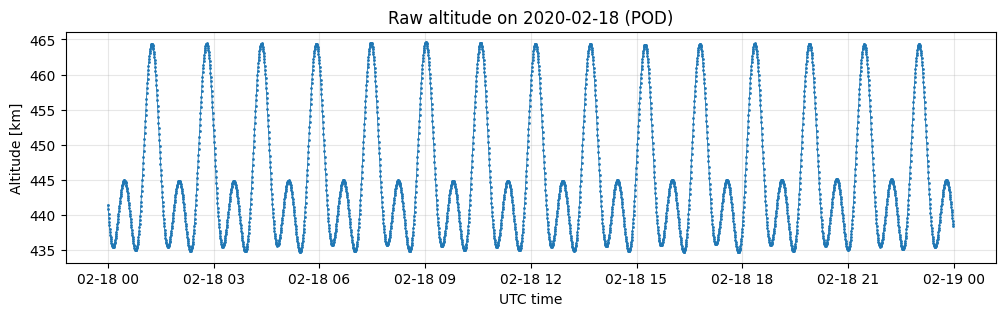

In [100]:
from cdflib import CDF, cdfepoch
def load_raw_swarm_day(in_dir, target_date, var_alt='altitude'):
    """CDFをそのまま読み込んで結合（補間・平均ゼロ）"""
    in_dir = Path(in_dir)
    cdfs = sorted(list(in_dir.glob("*.cdf")) + list(in_dir.glob("*.CDF")))
    if not cdfs:
        raise FileNotFoundError(f"No CDF in {in_dir}")

    rows = []
    for c in cdfs:
        with CDF(str(c)) as f:
            t = f.varget('time')
            den = np.array(f.varget('density'), dtype=float).ravel()
            alt = np.array(f.varget(var_alt), dtype=float).ravel()
            # 他に見たければ lat/lon/LT も同様に読む
        dt = np.array(cdfepoch.to_datetime(t))
        # pandasに投げて後で日付で切り出す
        df = pd.DataFrame({
            "time": pd.to_datetime(dt, utc=True),
            "density": den,
            "altitude": alt
        })
        rows.append(df)

    df = pd.concat(rows, ignore_index=True)
    df = df.dropna(subset=["time"]).sort_values("time")
    # その日のUTCで切り出し
    d0 = pd.Timestamp(target_date, tz="UTC")
    d1 = d0 + pd.Timedelta(days=1)
    df = df[(df["time"] >= d0) & (df["time"] < d1)].copy()
    # まれな重複を消す（同時刻に複数点があれば最初だけ）
    df = df.drop_duplicates(subset=["time"], keep="first")
    return df

def plot_raw_altitude(in_dir, date_str, label="POD", altitude_unit="km"):
    df = load_raw_swarm_day(in_dir, date_str, var_alt="altitude")
    if df.empty:
        print("No samples on", date_str)
        return
    y = df["altitude"].values.astype(float)
    # 単位（Swarm DNSのaltitudeは通常メートル）
    if altitude_unit.lower() == "km":
        y = y / 1000.0

    fig, ax = plt.subplots(figsize=(12,3))
    ax.plot(df["time"].values, y, linewidth=0.6, marker='.', markersize=2)
    ax.set_title(f"Raw altitude on {date_str} ({label})")
    ax.set_ylabel(f"Altitude [{altitude_unit}]")
    ax.set_xlabel("UTC time")
    ax.grid(True, alpha=0.3)


# 使い方例：
# POD（30s刻みのファイルでも、ここでは平均ゼロでそのままプロット）
# データがある実フォルダに変更してください
# 例) r"E:\data\Swarm\DNS\POD\Sat_A\2020\new"
plot_raw_altitude(in_dir=r"data/swarm/2020_POD", date_str="2020-02-18", label="POD", altitude_unit="km")

# ACC も同様に in_dir を ACC 側に変えるだけ
# plot_raw_altitude(in_dir=r"data/swarm/2020_ACC", date_str="2020-02-18", label="ACC", altitude_unit="km")


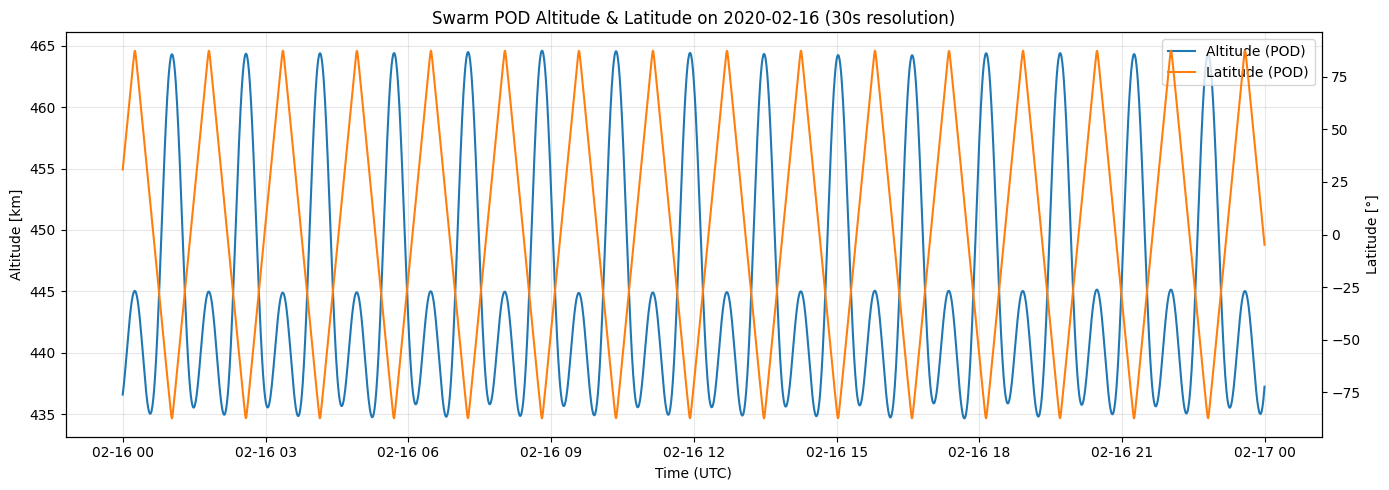

In [101]:
def day_slice(DNS: dict, d: date) -> pd.DataFrame:
    k = doy_2020(d)
    if k not in DNS: 
        return pd.DataFrame()
    df = DNS[k]["data"]
    if df.empty:
        return pd.DataFrame()
    start = pd.Timestamp(d.year, d.month, d.day)
    end   = start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    return df.loc[start:end].sort_index()

def prep_alt_lat(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out["alt_km"] = out["altitude"] / 1000.0  # m → km
    return out[["alt_km", "latitude"]]

def plot_alt_lat_pod(DNS_POD: dict, d: date):
    P = prep_alt_lat(day_slice(DNS_POD, d))
    if P.empty:
        print(f"No POD data on {d}.")
        return

    fig, ax1 = plt.subplots(figsize=(14,5))
    ax2 = ax1.twinx()

    ax1.plot(P.index, P["alt_km"], label="Altitude (POD)", color="tab:blue")
    ax2.plot(P.index, P["latitude"], label="Latitude (POD)", color="tab:orange")

    ax1.set_title(f"Swarm POD Altitude & Latitude on {d.isoformat()} (30s resolution)")
    ax1.set_xlabel("Time (UTC)")
    ax1.set_ylabel("Altitude [km]")
    ax2.set_ylabel("Latitude [°]")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    ax1.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    plt.show()

# ===== 実行例 =====
the_day = date(2020, 2, 16)   # 任意の日付に変更
plot_alt_lat_pod(DNS_POD, the_day)


In [102]:
# --- ユーティリティ ---
def doy_2020(d: date) -> int:
    return (d - date(2020,1,1)).days + 1

def _get_day_df(DNS_POD, d: date):
    k = doy_2020(d)
    if k not in DNS_POD or DNS_POD[k]["data"].empty:
        return None
    df = DNS_POD[k]["data"].copy()
    df["density"] = df["density"] * 1e13  # ×10^-13 へ
    return df

# --- 複数日プロット ---
def plot_pod_density_days(DNS_POD, dates, cmap="jet", use_log=False,
                          percent_clip=(0.05, 0.95), save_dir=None):
    """
    dates: [date(2020,2,16), date(2020,2,17), ...]
    use_log: True で対数カラースケール（密度のダイナミックレンジが広い時に）
    percent_clip: 共通カラー範囲を分位で指定 (下位, 上位)
    save_dir: 例 '/workspace/figs' を渡すと PNG 保存も行う
    """
    # まず全日分を集めて共通カラースケールを決める
    all_den = []
    day_dfs = {}
    for d in dates:
        df = _get_day_df(DNS_POD, d)
        if df is None: 
            print(f"[skip] No data for {d}")
            continue
        day_dfs[d] = df
        all_den.append(df["density"].values)
    if not all_den:
        print("No data for any of the given dates.")
        return
    all_den = np.concatenate(all_den)
    vmin, vmax = np.nanquantile(all_den, [percent_clip[0], percent_clip[1]])

    # 各日ごとに2段プロットを作成
    for d, df in day_dfs.items():
        df_am = df[df.index.hour < 12]
        df_pm = df[df.index.hour >= 12]

        fig, axes = plt.subplots(2, 1, figsize=(12,10),
                                 subplot_kw={"projection": ccrs.PlateCarree()})

        for ax, data, subtitle in zip(
            axes, [df_am, df_pm], [f"{d} (00–12 UTC)", f"{d} (12–24 UTC)"]
        ):
            ax.set_global()
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)

            kwargs = dict(cmap=cmap, s=5, transform=ccrs.PlateCarree(),
                          vmin=vmin, vmax=vmax)
            if use_log:
                from matplotlib.colors import LogNorm
                # vminが0以下なら微小値に丸める
                vmin_pos = max(vmin, 1e-6)
                kwargs["norm"] = LogNorm(vmin=vmin_pos, vmax=vmax)

            sc = ax.scatter(data["longitude"], data["latitude"],
                            c=data["density"], **kwargs)

            ax.set_xlabel("Longitude (Deg)")
            ax.set_ylabel("Latitude (Deg)")
            ax.set_title(subtitle)
            plt.colorbar(sc, ax=ax, label="Density [×10⁻¹³ kg/m³]")

        plt.suptitle("Swarm POD Density Observation", fontsize=16)
        plt.tight_layout()

        if save_dir:
            import os
            os.makedirs(save_dir, exist_ok=True)
            out = os.path.join(save_dir, f"POD_density_{d.isoformat()}.png")
            plt.savefig(out, dpi=200)
            print(f"saved: {out}")

        plt.show()


In [103]:
def doy_2020(d: date) -> int:
    return (d - date(2020,1,1)).days + 1

def _get_day_df(DNS_POD, d: date):
    k = doy_2020(d)
    if k not in DNS_POD or DNS_POD[k]["data"].empty:
        return None
    df = DNS_POD[k]["data"].copy()
    df["density"] = df["density"] * 1e13  # 単位変換
    return df

def plot_pod_density_days_LT(DNS_POD, dates, cmap="jet", use_log=False,
                             percent_clip=(0.05, 0.95), save_dir=None):
    """
    dates: [date(2020,2,16), ...]
    Local Solar Time (カラム: 'Local Solar Time') で分割して描画
    """
    # まず全データから共通カラースケールを決める
    all_den = []
    day_dfs = {}
    for d in dates:
        df = _get_day_df(DNS_POD, d)
        if df is None: 
            print(f"[skip] No data for {d}")
            continue
        if "local_solar_time" not in df.columns:
            raise ValueError("データに 'Local Solar Time' カラムがありません！")
        day_dfs[d] = df
        all_den.append(df["density"].values)
    if not all_den:
        print("No data for any of the given dates.")
        return
    all_den = np.concatenate(all_den)
    vmin, vmax = np.nanquantile(all_den, [percent_clip[0], percent_clip[1]])

    # 各日ごとに LT で分割してプロット
    for d, df in day_dfs.items():
        df_am = df[df["local_solar_time"] < 12]  # 午前
        df_pm = df[df["local_solar_time"] >= 12] # 午後

        fig, axes = plt.subplots(2, 1, figsize=(12,10),
                                 subplot_kw={"projection": ccrs.PlateCarree()})

        for ax, data, subtitle in zip(
            axes, [df_am, df_pm],
            [f"{d} (LT < 12h)", f"{d} (LT ≥ 12h)"]
        ):
            ax.set_global()
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)

            kwargs = dict(cmap=cmap, s=5, transform=ccrs.PlateCarree(),
                          vmin=vmin, vmax=7)
            if use_log:
                from matplotlib.colors import LogNorm
                vmin_pos = max(vmin, 1e-6)
                kwargs["norm"] = LogNorm(vmin=vmin_pos, vmax=vmax)

            sc = ax.scatter(data["longitude"], data["latitude"],
                            c=data["density"], **kwargs)

            ax.set_xlabel("Longitude (Deg)")
            ax.set_ylabel("Latitude (Deg)")
            ax.set_title(subtitle)
            plt.colorbar(sc, ax=ax, label="Density [×10⁻¹³ kg/m³]")

        plt.suptitle("Swarm POD Density Observation (Local Time split)", fontsize=16)
        plt.tight_layout()

        if save_dir:
            import os
            os.makedirs(save_dir, exist_ok=True)
            out = os.path.join(save_dir, f"POD_density_LTsplit_{d.isoformat()}.png")
            plt.savefig(out, dpi=200)
            print(f"saved: {out}")

        plt.show()


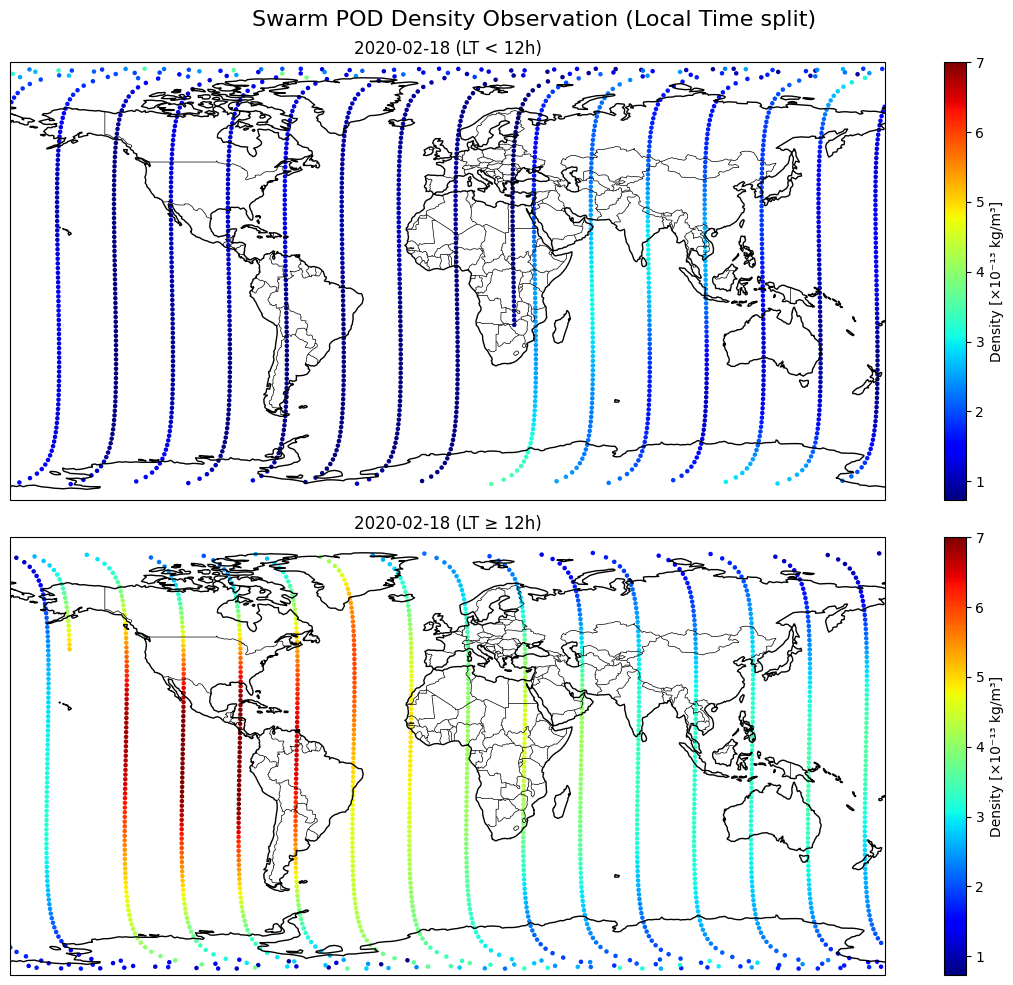

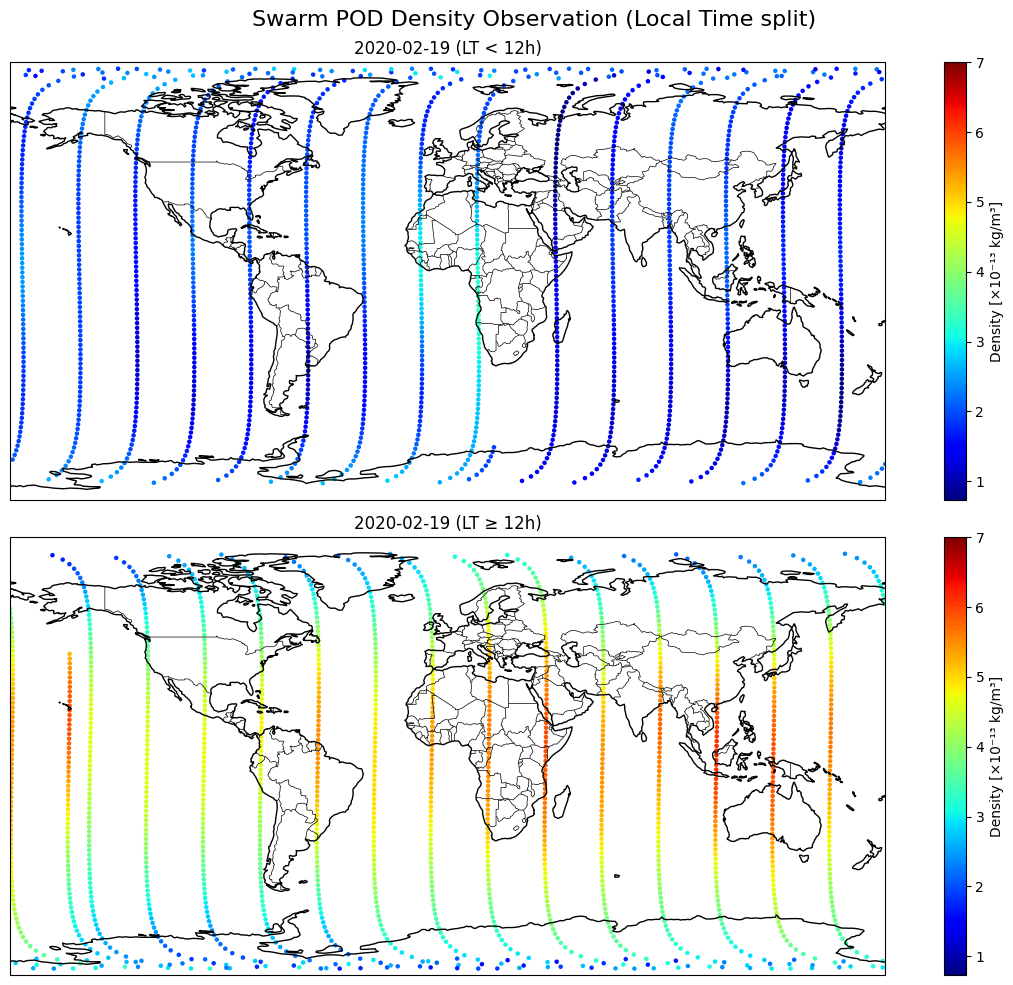

In [104]:
from datetime import date

dates = [date(2020,2,18), date(2020,2,19)]
plot_pod_density_days_LT(DNS_POD, dates, cmap="jet", use_log=False)


In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import date
# 追加インポート
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def add_latlon_grid(ax, dx=60, dy=30):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='0.5', alpha=0.6, linestyle='--')
    gl.top_labels   = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, dx))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,   91,  dy))
    gl.xformatter = LongitudeFormatter(number_format='.0f', degree_symbol='°')
    gl.yformatter = LatitudeFormatter(number_format='.0f', degree_symbol='°')
    gl.xlabel_style = {'size': 9}
    gl.ylabel_style = {'size': 9}
    return gl


# ---------- 基本ユーティリティ ----------
def doy_2020(d: date) -> int:
    return (d - date(2020,1,1)).days + 1

def _get_day_df(DNS_POD, d: date):
    k = doy_2020(d)
    if k not in DNS_POD or DNS_POD[k]["data"].empty:
        return None
    df = DNS_POD[k]["data"].copy()
    df["density"] = df["density"] * 1e13   # ×10^-13 へ
    return df.sort_index()

def _format_lt(lt_float: float) -> str:
    lt_float = lt_float % 24.0
    h = int(np.floor(lt_float))
    m = int(round((lt_float - h) * 60)) % 60
    return f"{h:02d}:{m:02d}"

# ---------- パス分割 & 代表LT推定 ----------
def _split_passes_by_lat(df: pd.DataFrame):
    """緯度の増減の符号が切り替わるところでパス分割（昇交/降交）。"""
    lat = df["latitude"].to_numpy()
    dlat = np.diff(lat)
    sign = np.sign(dlat)
    # 0 を前後で補完
    s = pd.Series(sign).replace(0, np.nan).ffill().bfill()
    sign = s.to_numpy()
    cuts = np.where(np.diff(sign) != 0)[0] + 1

    # 時間ギャップでも分割（安全策）
    tdiff = df.index.to_series().diff().to_numpy()
    big_gap = np.where(tdiff[1:] > pd.Timedelta("5min"))[0] + 1
    cuts = np.unique(np.concatenate([cuts, big_gap]))

    edges = np.r_[0, cuts, len(df)]
    segs = []
    for i in range(len(edges)-1):
        seg = df.iloc[edges[i]:edges[i+1]]
        if len(seg) >= 10:
            segs.append(seg)
    return segs

def _representative_lt_from_equator(df_group: pd.DataFrame) -> float:
    """
    午前/午後グループ内の各パスで「赤道交差付近」の LT を拾い、
    その中央値を代表LTとする。
    """
    eq_lts = []
    for seg in _split_passes_by_lat(df_group):
        # そのパス内で |lat| が最小の点を「赤道交差近傍」とみなす
        j = np.argmin(np.abs(seg["latitude"].to_numpy()))
        eq_lts.append(float(seg["local_solar_time"].iloc[j]))
    if len(eq_lts) == 0:
        # フォールバック：グループ全体の LT 中央
        return float(np.nanmedian(df_group["local_solar_time"].to_numpy()))
    # 午前(<12) / 午後(>=12) に分けているため、そのまま中央値でOK
    return float(np.nanmedian(eq_lts))

# ---------- メイン描画 ----------
def plot_pod_density_days_LT_annotated(
    DNS_POD, dates,
    cmap="jet", use_log=False,
    vmin=None, vmax=None, percent_clip=(0.05, 0.95),
    add_time_labels=True, label_time="UTC", label_every="10min",
    label_fontsize=7
):
    # カラー範囲の決定
    all_den, day_dfs = [], {}
    for d in dates:
        df = _get_day_df(DNS_POD, d)
        if df is None:
            print(f"[skip] No data for {d}")
            continue
        if "local_solar_time" not in df.columns:
            raise ValueError("データに 'local_solar_time' 列がありません。")
        day_dfs[d] = df
        all_den.append(df["density"].values)

    if not day_dfs:
        print("No data for any of the given dates.")
        return

    if vmin is None or vmax is None:
        all_den = np.concatenate(all_den)
        qlo, qhi = percent_clip if percent_clip else (0.0, 1.0)
        vmin = np.nanquantile(all_den, qlo)
        vmax = np.nanquantile(all_den, qhi)

    for d, df in day_dfs.items():
        # AM/PM を LT で分割
        am = df[df["local_solar_time"] < 12]
        pm = df[df["local_solar_time"] >= 12]

        # 代表LT（赤道交差近傍の中央値）
        rep_lt_am = _representative_lt_from_equator(am) if not am.empty else np.nan
        rep_lt_pm = _representative_lt_from_equator(pm) if not pm.empty else np.nan
        rep_am_str = _format_lt(rep_lt_am) if np.isfinite(rep_lt_am) else "--:--"
        rep_pm_str = _format_lt(rep_lt_pm) if np.isfinite(rep_lt_pm) else "--:--"

        fig, axes = plt.subplots(
            2, 1, figsize=(12, 10),
            subplot_kw={"projection": ccrs.PlateCarree()}
        )

        for ax, data, ylab, subtitle in zip(
            axes,
            [am, pm],
            [f"Latitude ({rep_am_str} LT)", f"Latitude ({rep_pm_str} LT)"],
            [f"{d} (LT < 12h)", f"{d} (LT ≥ 12h)"]
        ):
            ax.set_global()
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            add_latlon_grid(ax, dx=60, dy=30)  # 経緯度目盛

            # 散布図（密度カラー）
            kwargs = dict(cmap=cmap, s=5, transform=ccrs.PlateCarree(),
                          vmin=vmin, vmax=vmax)
            if use_log:
                from matplotlib.colors import LogNorm
                kwargs["norm"] = LogNorm(vmin=max(vmin, 1e-6), vmax=vmax)

            sc = ax.scatter(data["longitude"], data["latitude"],
                            c=data["density"], **kwargs)

            ax.set_xlabel("Longitude (Deg)")
            ax.set_ylabel(ylab)
            ax.set_title(subtitle)
            plt.colorbar(sc, ax=ax, label="Density [×10⁻¹³ kg/m³]")

            # パスごとに時刻ラベル（UTC or LT）
            if add_time_labels and not data.empty:
                for seg in _split_passes_by_lat(data):
                    sampled = (seg.resample(label_every).first()
                                 .dropna(subset=["longitude","latitude"]))
                    for idx, row in sampled.iterrows():
                        if label_time.upper() == "LT":
                            txt = _format_lt(float(row["local_solar_time"]))
                        else:  # UTC（パス内で単調）
                            txt = pd.Timestamp(idx).strftime("%H:%M")
                        ax.text(row["longitude"], row["latitude"], txt,
                                transform=ccrs.PlateCarree(),
                                fontsize=label_fontsize, ha="center", va="center",
                                path_effects=[pe.withStroke(linewidth=2, foreground="white")])

        plt.suptitle("Swarm POD Density", fontsize=16)
        plt.tight_layout()
        plt.show()



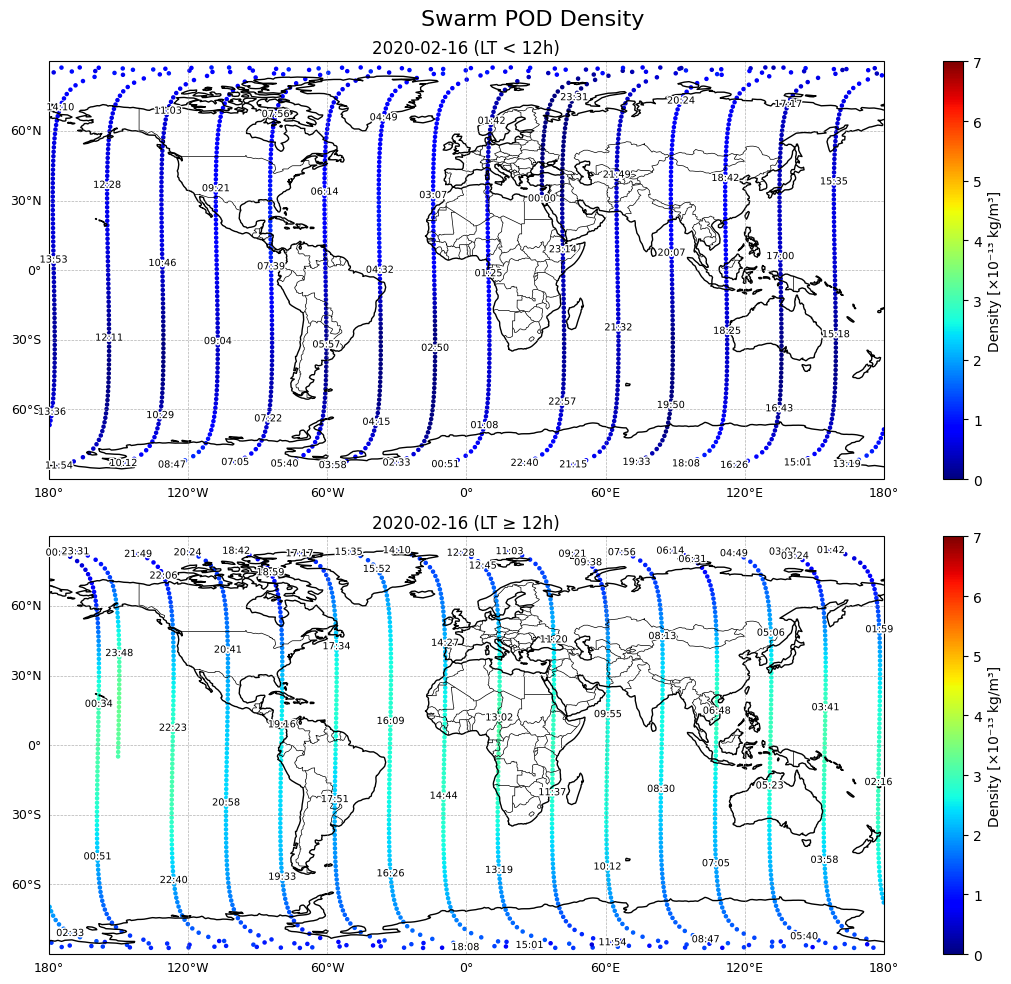

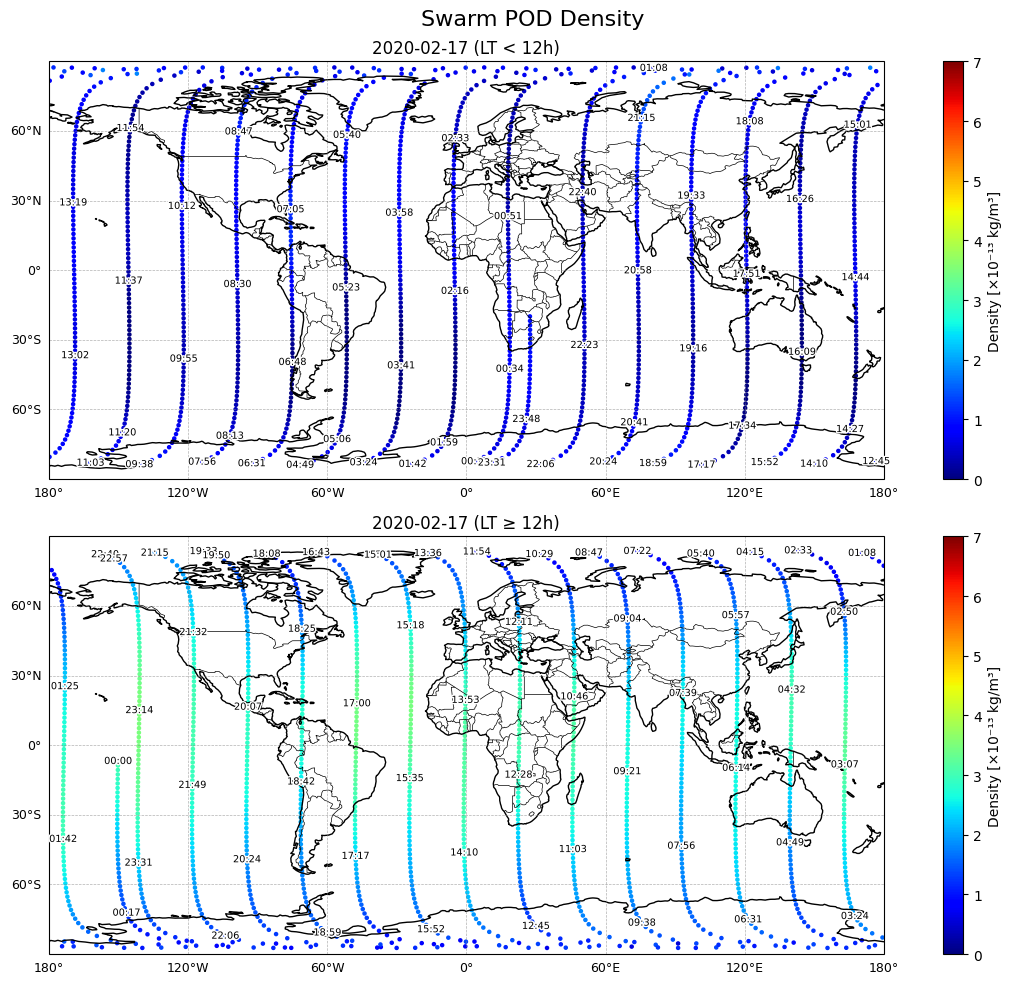

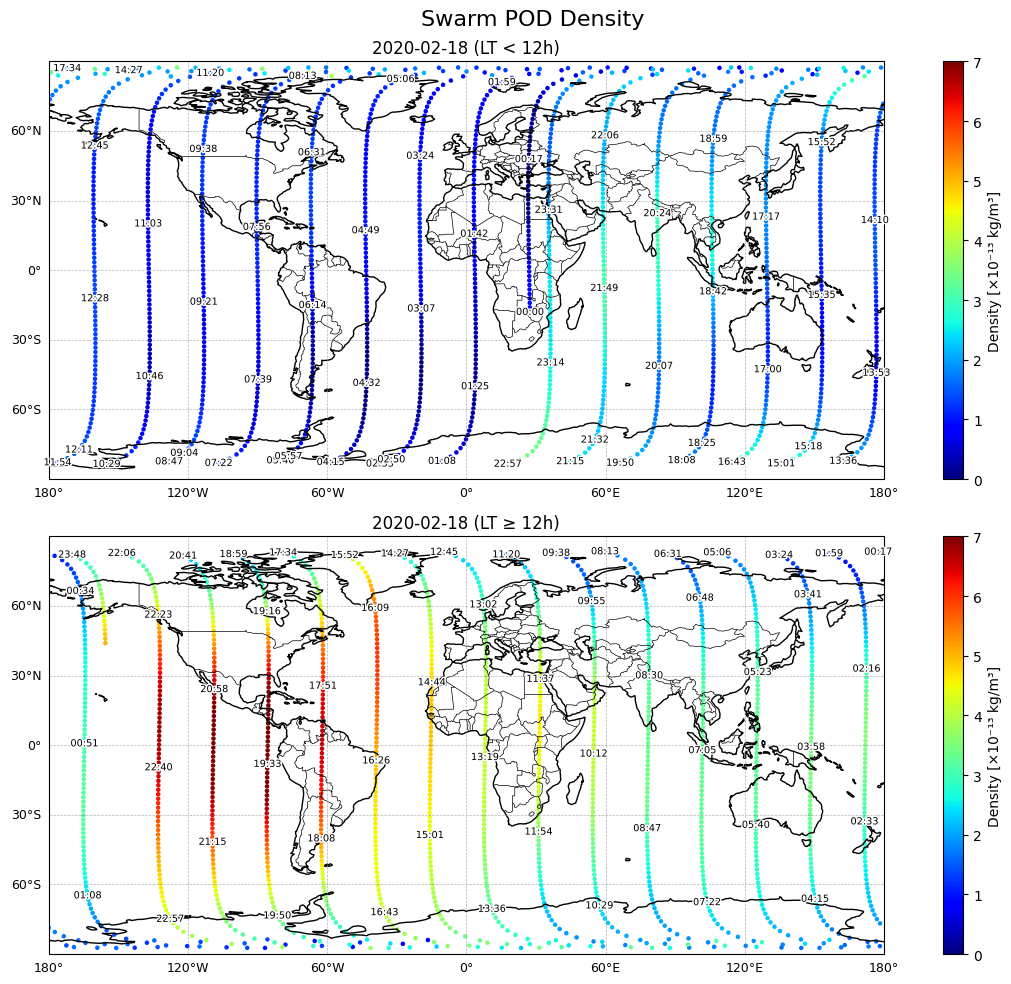

In [106]:
from datetime import date

dates = [date(2020,2,16), date(2020,2,17), date(2020,2,18)]
plot_pod_density_days_LT_annotated(
    DNS_POD, dates,
    cmap="jet",
    vmin=0, vmax=7,            # ← 例：固定レンジ
    add_time_labels=True,
    label_time="UTC",          # パス内で単調に並ぶ
    label_every="17min",       # ラベル間隔
    label_fontsize=7
)
